In [1]:
import os
from lstm_clf import *
from torch import optim
import seaborn
seaborn.set()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LightSource, Normalize
from torch.nn import functional as F
import json

# train

In [2]:
init_seed()
hdim = 100
mdl = LSTM(6 + 1, 6, hdim)
logs = train(mdl, 40000, 200, 100)

{'#seqs': 399, 'acc': 0.51, 'acc_along': [0.525, 0.53, 0.485, 0.5], 'loss': 1.4378, 'seen%': 0.27}
{'#seqs': 799, 'acc': 0.5875, 'acc_along': [0.59, 0.595, 0.635, 0.53], 'loss': 1.0232, 'seen%': 0.44}


KeyboardInterrupt: 

In [2]:
mdl_name = f'lstm-clf-repeat-mky-whole.mdl'
torch.save(mdl, mdl_name)
log_name = 'lstm-clf-repeat-mky-whole.log'
with open(log_name, 'w') as f:
    logs_json = json.dumps(logs)
    json.dump(logs_json, f)

NameError: name 'mdl' is not defined

In [3]:
train_curve = np.array([log['acc_along'] for log in logs])
train_curve.shape

NameError: name 'logs' is not defined

In [4]:
nseqs = [log['#seqs'] for log in logs]
losses = [log['loss'] for log in logs]

NameError: name 'logs' is not defined

In [5]:
def draw_training_curve(logs, kept=0.5):
    nlogs_kept = int(kept * len(logs))
    acc_along = np.array([log['acc_along'] for log in logs])[:nlogs_kept]
    # acc_along: (nseqs, 4)
    nseqs = [log['#seqs'] for log in logs][:nlogs_kept]
    losses = [log['loss'] for log in logs][:nlogs_kept]
    fig, ax = plt.subplots()
    fig.dpi = 100
    for i in range(train_curve.shape[-1]):
        plt.plot(nseqs, acc_along[:, i], label=f'pos {i}')
    plt.plot(nseqs, losses, label=f'loss')
    plt.legend()
    plt.ylabel('Accuracy')
    plt.xlabel('#sequences')
    plt.show()
    return acc_along.mean(axis=0)

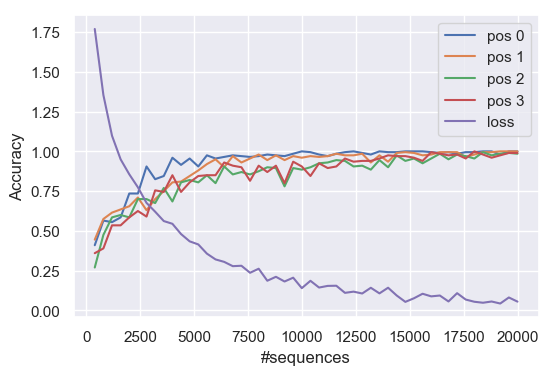

array([0.928 , 0.8994, 0.8509, 0.8569])

In [11]:
draw_training_curve(logs)

# verification of memory erasing

# analysis

In [6]:
mdl = torch.load('lstm-clf-repeat-mky-whole.mdl')

/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [7]:
inp_set = []
name_lst = []
for x0 in range(6):
    for x1 in range(6):
        for x2 in range(6):
            for x3 in range(6):
                inp = build_batch(x0, x1, x2, x3)
                inp_set.append(inp)
                name_lst.append(f'{x0}{x1}{x2}{x3}')

In [8]:
def plot(hs, dpi=80, fontsize=10, grid=False, add_cbar=True, show_ylabel=True, title=None):
    bsz, seq_len, hdim = hs.shape
    fig, ax = plt.subplots()
    fig.dpi = dpi
    im = ax.imshow(hs.detach().numpy()[0].transpose(), 
                   interpolation='gaussian')  # (hdim, seq_len)
    if add_cbar:
        cbar = ax.figure.colorbar(im, ax=ax)
    plt.grid(grid)
#     plt.xticks(list(range(seq_len)), fontsize=fontsize)
    plt.xlabel('time step')
    if show_ylabel:
        plt.ylabel('dimension/cell index')
    if title is not None:
        plt.title(title)
    plt.show()

In [9]:
def build_batch(x0, x1, x2, x3):
    seq = torch.LongTensor([[x0, x1, x2, x3]])
    seq = embeddings(seq)
    idim = 6 + 1
    width = idim - 1
    seq_len = 4
    inp = torch.zeros(1, seq_len + 1, width + 1)
    inp[:, :seq_len, :width] = seq
    inp[:, seq_len, width] = 1.0  # delimiter in our control channel
    return inp.float()

In [10]:
inp = build_batch(0, 0, 0, 0)
tar = mdl(inp, 4)

In [11]:
def build_and_plot(x0, x1, x2, x3, to_plot='hs'):
    inp = build_batch(x0, x1, x2, x3)
    mdl(inp, 4)
    plot(mdl.get_hs(to_plot), 300, 2)

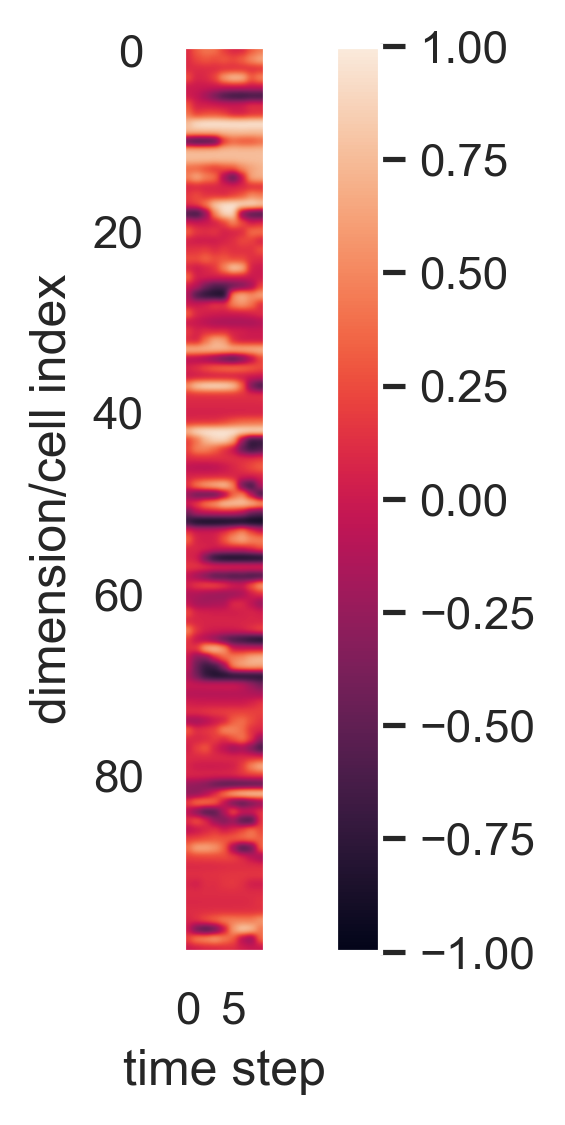

In [12]:
build_and_plot(0, 0, 0, 0)

In [13]:
embeddings.weight.requires_grad = True

In [14]:
inp = build_batch(0, 1, 2, 3)
tar = mdl(inp, 4, retain_grad=True)

In [15]:
inp[0].t()

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]], grad_fn=<TBackward>)

In [16]:
def round_arr(arr, precision=3):
    assert len(arr.shape) == 2
    res = np.zeros(arr.shape)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            res[i, j] = round(arr[i, j], precision)
    return res

In [17]:
def grad_tar2inp(x0, x1, x2, x3, tar_pos, 
                 apply_abs=False, add_cbar=True, show_ylabel=True):
    inp = build_batch(x0, x1, x2, x3)
#     print(inp[0].t())
    tar = mdl(inp, 4, retain_grad=True)
    tar = F.softmax(tar, dim=-1)
    print(round_arr(tar[0].t().detach().numpy()))
    # tar: (bsz, seq_len, odim)
    tar[0, tar_pos].max().backward()
#     tar[0, tar_pos].abs().sum().backward()
#     plot(inp.grad.abs(), grid=True)
    if apply_abs:
        plot(inp.grad.abs(), grid=True, add_cbar=add_cbar, show_ylabel=show_ylabel)
    else:
        plot(inp.grad, grid=True, add_cbar=add_cbar, show_ylabel=show_ylabel)

In [18]:
tar.shape

torch.Size([1, 4, 6])

target position 0
[[0.954      0.001      0.         0.        ]
 [0.046      0.99800003 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.001      0.         0.        ]]


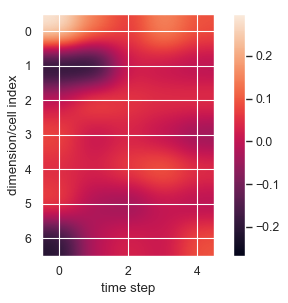

target position 1
[[0.954      0.001      0.         0.        ]
 [0.046      0.99800003 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.001      0.         0.        ]]


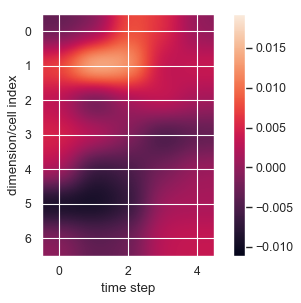

target position 2
[[0.954      0.001      0.         0.        ]
 [0.046      0.99800003 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.001      0.         0.        ]]


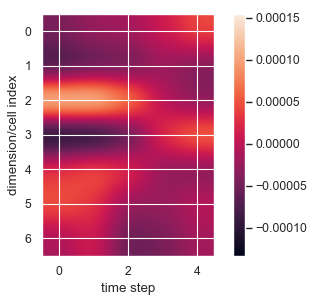

target position 3
[[0.954      0.001      0.         0.        ]
 [0.046      0.99800003 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.001      0.         0.        ]]


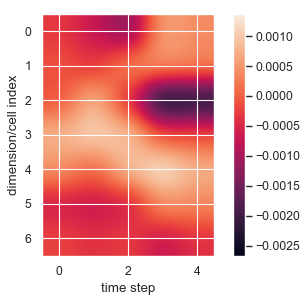

In [19]:
for tar_pos in range(4):
    print(f'target position {tar_pos}')
    grad_tar2inp(0, 1, 2, 3, tar_pos, add_cbar=True)

target position 0
[[0.954      0.001      0.         0.        ]
 [0.046      0.99800003 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.001      0.         0.        ]]


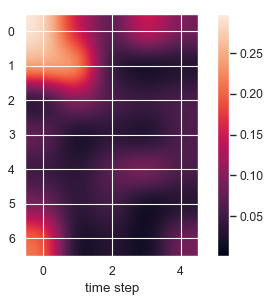

target position 1
[[0.954      0.001      0.         0.        ]
 [0.046      0.99800003 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.001      0.         0.        ]]


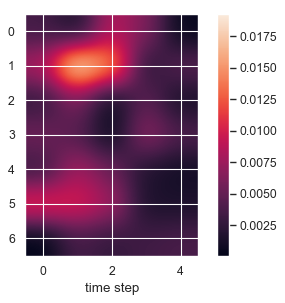

target position 2
[[0.954      0.001      0.         0.        ]
 [0.046      0.99800003 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.001      0.         0.        ]]


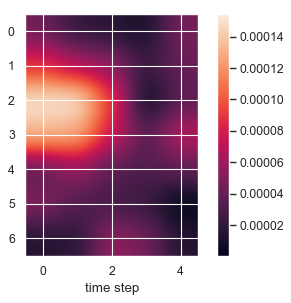

target position 3
[[0.954      0.001      0.         0.        ]
 [0.046      0.99800003 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.001      0.         0.        ]]


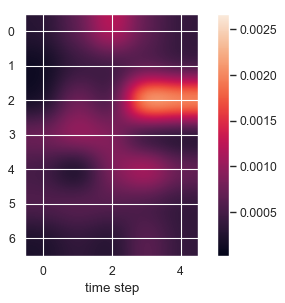

In [20]:
for tar_pos in range(4):
    print(f'target position {tar_pos}')
    grad_tar2inp(0, 1, 2, 3, tar_pos, apply_abs=True, show_ylabel=False)

In [122]:
def grad_tar2hs(x0, x1, x2, x3, tar_pos, 
                hs='hs', k=80, apply_abs=False, add_cbar=True, 
                filter_small=False,
                show_ylabel=True):
    inp = build_batch(x0, x1, x2, x3)
#     print(inp[0].t())
    tar = mdl(inp, 4, retain_grad=True)
    tar = F.softmax(tar, dim=-1)
    print(round_arr(tar[0].t().detach().numpy()))
    # tar: (bsz, seq_len, odim)
    tar[0, tar_pos].max().backward()
#     tar[0, tar_pos].abs().sum().backward()
#     plot(inp.grad.abs(), grid=True)
    grad = mdl.get_grad(hs)[0]
    if apply_abs:
        grad = grad.abs()
    
        # grad: (ilen+tlen, hdim)
    seq_len, hdim = grad.shape
    topk_vals, topk_indices = grad.topk(dim=1, k=k)  # topk_xxx: (ilen+tlen, 10)
    if filter_small:
        min_boundary = topk_vals.min(dim=-1)[0]  # min_boundary: (ilen+tlen,)
#         print('before', grad)
        mask = (grad < min_boundary.unsqueeze(-1))
        grad = grad.clone().masked_fill_(mask, 0)
#         print('after', grad)
        
#     inherent = set(range(hdim))
    inherent = set(topk_indices[tar_pos].detach().numpy().tolist())
    for influential_dims in topk_indices[:4]:
        inherent &= set(influential_dims.detach().numpy().tolist())
    print('inherent:', sorted(inherent))
#     plt.hist(grad.view(-1))
    
    plot(grad[None], dpi=300, fontsize=4,
         grid=False, add_cbar=add_cbar, show_ylabel=show_ylabel)

target position 0
[[0.954      0.001      0.         0.        ]
 [0.046      0.99800003 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.001      0.         0.        ]]
inherent: [0, 2, 4, 5, 9, 12, 17, 22, 29, 30, 33, 35, 36, 39, 40, 42, 43, 44, 46, 48, 50, 52, 78, 87, 88, 90, 93, 98]


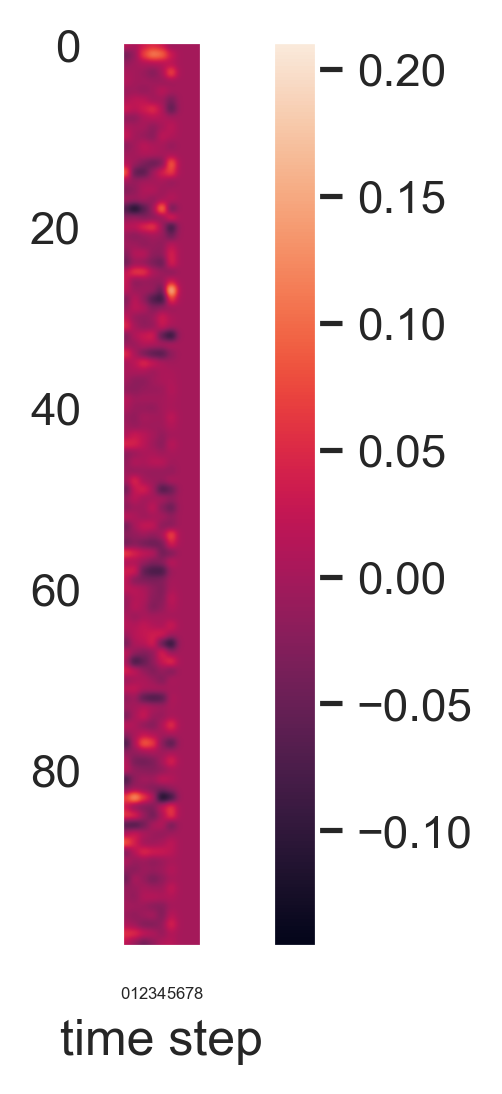

target position 1
[[0.954      0.001      0.         0.        ]
 [0.046      0.99800003 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.001      0.         0.        ]]
inherent: [2, 8, 9, 11, 12, 15, 21, 25, 29, 33, 36, 38, 40, 41, 42, 45, 46, 47, 78, 79, 80, 81, 91, 93, 98]


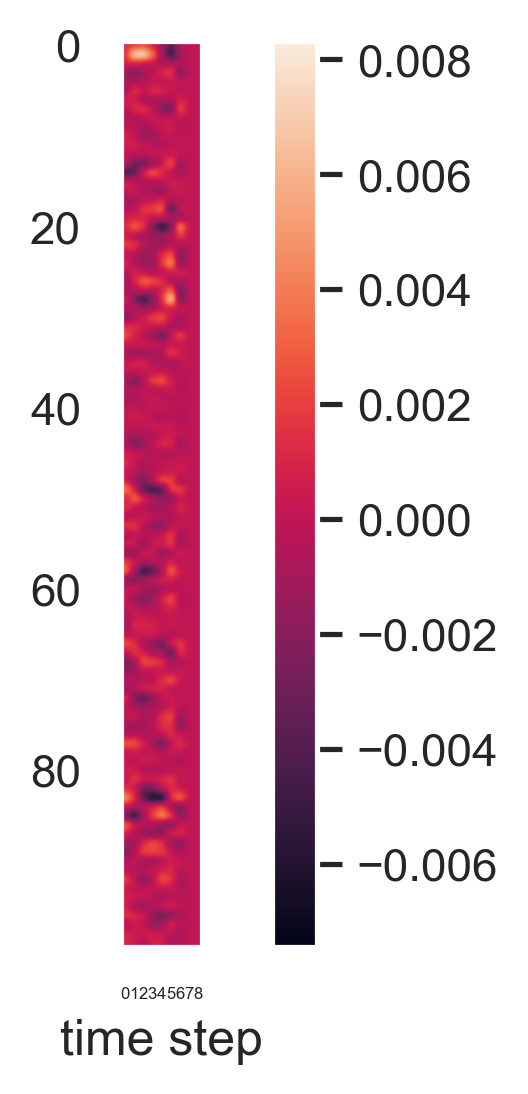

target position 2
[[0.954      0.001      0.         0.        ]
 [0.046      0.99800003 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.001      0.         0.        ]]
inherent: [4, 8, 11, 15, 33, 36, 38, 39, 41, 43, 45, 47, 50, 52, 61, 78, 80, 91, 93, 94, 95]


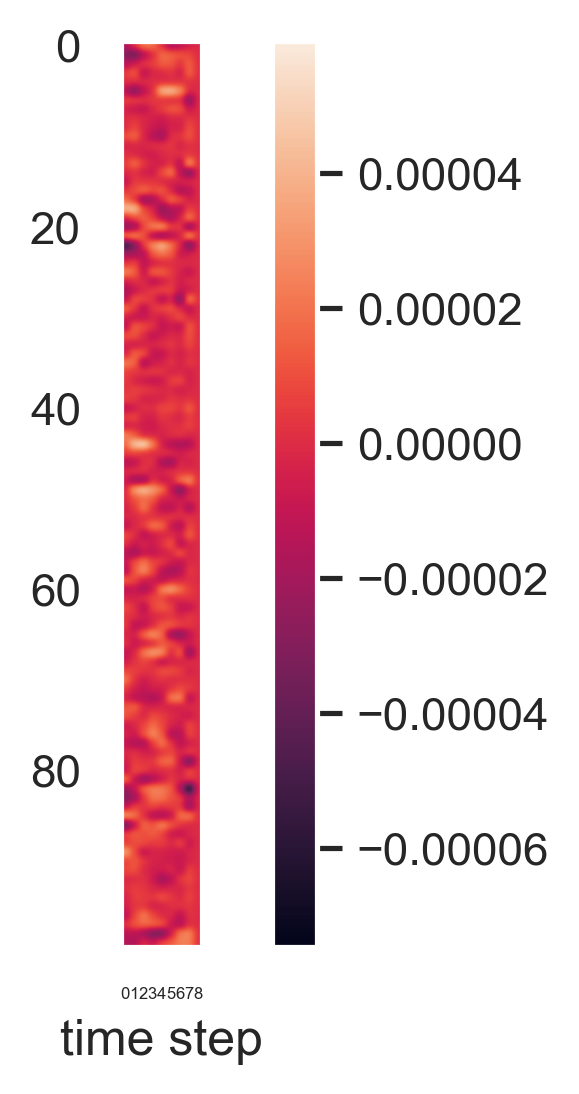

target position 3
[[0.954      0.001      0.         0.        ]
 [0.046      0.99800003 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.001      0.         0.        ]]
inherent: [4, 8, 15, 33, 36, 39, 41, 42, 45, 46, 52, 54, 57, 73, 90, 91, 93, 95]


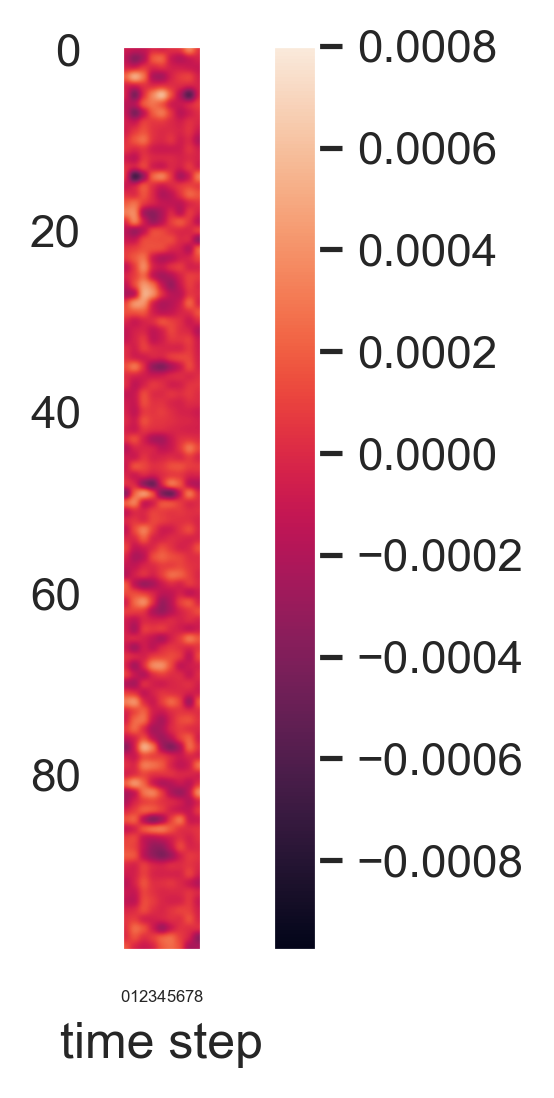

In [94]:
for tar_pos in range(4):
    print(f'target position {tar_pos}')
    grad_tar2hs(0, 1, 2, 3, tar_pos, apply_abs=False, show_ylabel=False)

In [53]:
set0 - (set1 | set2 | set3)

{7, 8, 29, 30, 32, 33, 38, 47, 51}

In [54]:
set1 - (set0 | set2 | set3)

{27, 48, 49, 50, 88, 94, 95, 96}

In [55]:
set2 - (set0 | set1 | set3)

{13, 31, 35, 44, 81, 90}

In [56]:
set3 - (set0 | set1 | set2)

{2, 14, 46, 53, 67, 76, 91}

Text(0.5, 0.98, 'Categorical Plotting')

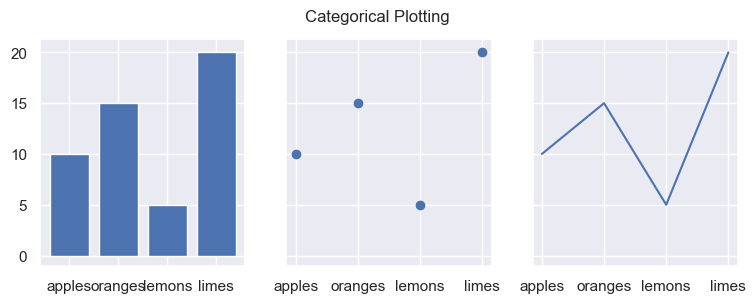

In [137]:
data = {'apples': 10, 'oranges': 15, 'lemons': 5, 'limes': 20}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
fig.dpi = 100
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

In [361]:
def grad_tar2hs_pos(x0, x1, x2, x3, tar_pos, 
                    hs='hs', k=80, apply_abs=False, add_cbar=True, 
                    filter_small=False,
                    show_ylabel=True):
    inp = build_batch(x0, x1, x2, x3)

    tar = mdl(inp, 4, retain_grad=True)
    tar = F.softmax(tar, dim=-1)
#     print(round_arr(tar[0].t().detach().numpy()))
    # tar: (bsz, seq_len, odim)
    tar[0, tar_pos].max().backward()

    grad = mdl.get_grad(hs)[0]
    if apply_abs:
        grad = grad.abs()
    
        # grad: (ilen+tlen, hdim)
    seq_len, hdim = grad.shape
    topk_vals, topk_indices = grad.topk(dim=1, k=k)  # topk_xxx: (ilen+tlen, 10)
    if filter_small:
        min_boundary = topk_vals.min(dim=-1)[0]  # min_boundary: (ilen+tlen,)

        mask = (grad < min_boundary.unsqueeze(-1))
        grad = grad.clone().masked_fill_(mask, 0)

        

    inherent = set(topk_indices[tar_pos].detach().numpy().tolist())
    for influential_dims in topk_indices[:4]:
        inherent &= set(influential_dims.detach().numpy().tolist())
#     print('inherent:', sorted(inherent))

    
    im = plt.imshow(grad.detach().numpy().transpose())  # (hdim, seq_len)
#     if add_cbar:
#         cbar = ax.figure.colorbar(im, ax=ax)
    plt.grid(False)
    plt.yticks(list(range(0, 100, 2)), fontsize=5)
    plt.xticks(list(range(4+1+4)), fontsize=5)
#     ax.set_xticks(list(range(seq_len)), fontsize=2)
#     plt.xlabel('time step')
#     if show_ylabel:
#         plt.ylabel('dimension/cell index')
#     plt.show()

In [376]:
def grad_tar2hs(x0, x1, x2, x3, k=10, title=None):
    fig, _ = plt.subplots()
    fig.dpi = 300
    for tar_pos in range(4):
        plt.subplot(1, 4+1, tar_pos + 1)
#         print(f'target position {tar_pos}')
#         plt.suptitle(f'y{tar_pos}')
        grad_tar2hs_pos(x0, x1, x2, x3, tar_pos, k=k, 
                        filter_small=True, hs='cs', apply_abs=False, show_ylabel=False)
        if tar_pos != 0:
            plt.yticks([])
        plt.title(f'y{tar_pos}={[x0, x1, x2, x3][tar_pos]}', fontsize=5)

    plt.subplots_adjust(bottom=0.1, right=0.6, top=0.9)
    cax = plt.axes([0.5, 0.4, 0.01, 0.2])
    plt.colorbar(cax=cax)
    plt.show()

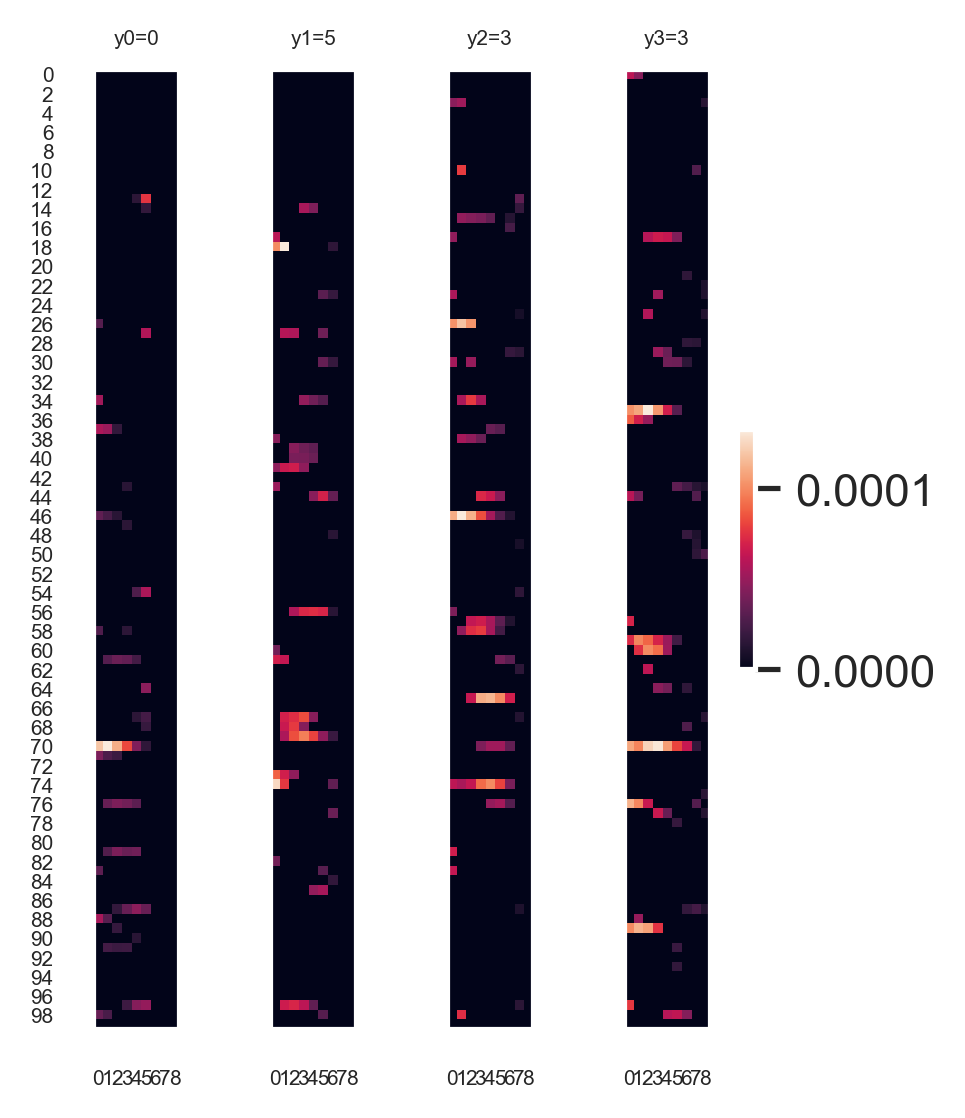

In [379]:
v = list(range(6))
x0 = random.choice(v)
x1 = random.choice(v)
x2 = random.choice(v)
x3 = random.choice(v)
grad_tar2hs(x0, x1, x2, x3)

In [93]:
def plot_weight(weight):
    fig, ax = plt.subplots()
    fig.dpi = 150
    plt.grid(False)
    plt.imshow(weight.detach().numpy(), interpolation='gaussian')

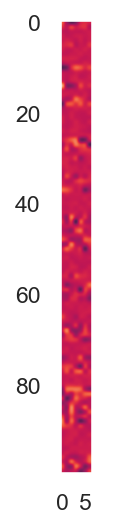

In [97]:
i = 2
plot_weight(mdl.w_ih[100 * i: 100 * (i+1)])

In [84]:
mdl.w_ih.shape

torch.Size([400, 7])

In [14]:
def plot_hs(ax, x0, x1, x2, x3, hs='hs'):
    name = hs
    inp = build_batch(x0, x1, x2, x3)
    tar = mdl(inp, 4, retain_grad=True)
#     hs = mdl.get_hs(hs)
    hs = mdl.get_hs(hs)[:, :, [49, 50, 83, 88]]
    bsz, seq_len, hdim = hs.shape
#     hs = hs.abs()
    im = ax.imshow(hs.detach().numpy()[0].transpose(), 
#                    interpolation='gaussian'
                  )  # (hdim, seq_len)
#     cbar = ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
#     plt.xlabel('time step')
#     if show_ylabel:
#         plt.ylabel('dimension/cell index')
#     if title is not None:
#     plt.title(f'{name}-{x0}{x1}{x2}{x3}')
#     plt.show()

In [22]:
def plot_hs_random(name='cs', k=5):
    indices = random.sample(list(range(len(name_lst))), k=k)
    fig, axs = plt.subplots(1, k, figsize=(10, 8), sharey=True)
    fig.dpi = 300
    for i, idx in enumerate(indices):
        x0, x1, x2, x3 = map(int, list(name_lst[idx]))
        plot_hs(axs[i], x0, x1, x2, x3, name)
        axs[i].set_title(f'{name}-{x0}{x1}{x2}{x3}')
#     cax = plt.axes([0.85, 0.1, 0.075, 0.8])
#     plt.colorbar(cax=cax)
    plt.show()

In [258]:
def plot_hs(x0, x1, x2, x3, hs='hs'):
    name = hs
    inp = build_batch(x0, x1, x2, x3)
    tar = mdl(inp, 4, retain_grad=True)
    hs = mdl.get_hs(hs).abs()
#     hs = mdl.get_hs(hs)[:, :, [49, 50, 83, 88]]
    bsz, seq_len, hdim = hs.shape
#     hs = hs.abs()
    plt.imshow(hs.detach().numpy()[0].transpose(), 
#                    interpolation='gaussian'
                  )  # (hdim, seq_len)
#     cbar = ax.figure.colorbar(im, ax=ax)
    plt.grid(False)
#     plt.xlabel('time step')
#     if show_ylabel:
#         plt.ylabel('dimension/cell index')
#     if title is not None:
#     plt.title(f'{name}-{x0}{x1}{x2}{x3}')
#     plt.show()

In [259]:
def plot_hs_random(name='cs', k=5):
    fig, _= plt.subplots()
    fig.dpi = 300
    indices = random.sample(list(range(len(name_lst))), k=k)
    for i, idx in enumerate(indices):
        plt.subplot(1, k + 1, i + 1)
#         ax.set_figure(plt.figure(dpi=100))
#         fig.dpi = 300
        x0, x1, x2, x3 = map(int, list(name_lst[idx]))
        plot_hs(x0, x1, x2, x3, name)
        plt.title(f'{name}-{x0}{x1}{x2}{x3}', fontsize=5)
        plt.xticks(list(range(4 + 1 + 4)), fontsize=5)
        plt.yticks(list(range(0, 100, 2)), fontsize=5)
        if i != 0:
            plt.yticks([])

    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.7, 0.4, 0.01, 0.2])
    plt.colorbar(cax=cax)
    plt.show()

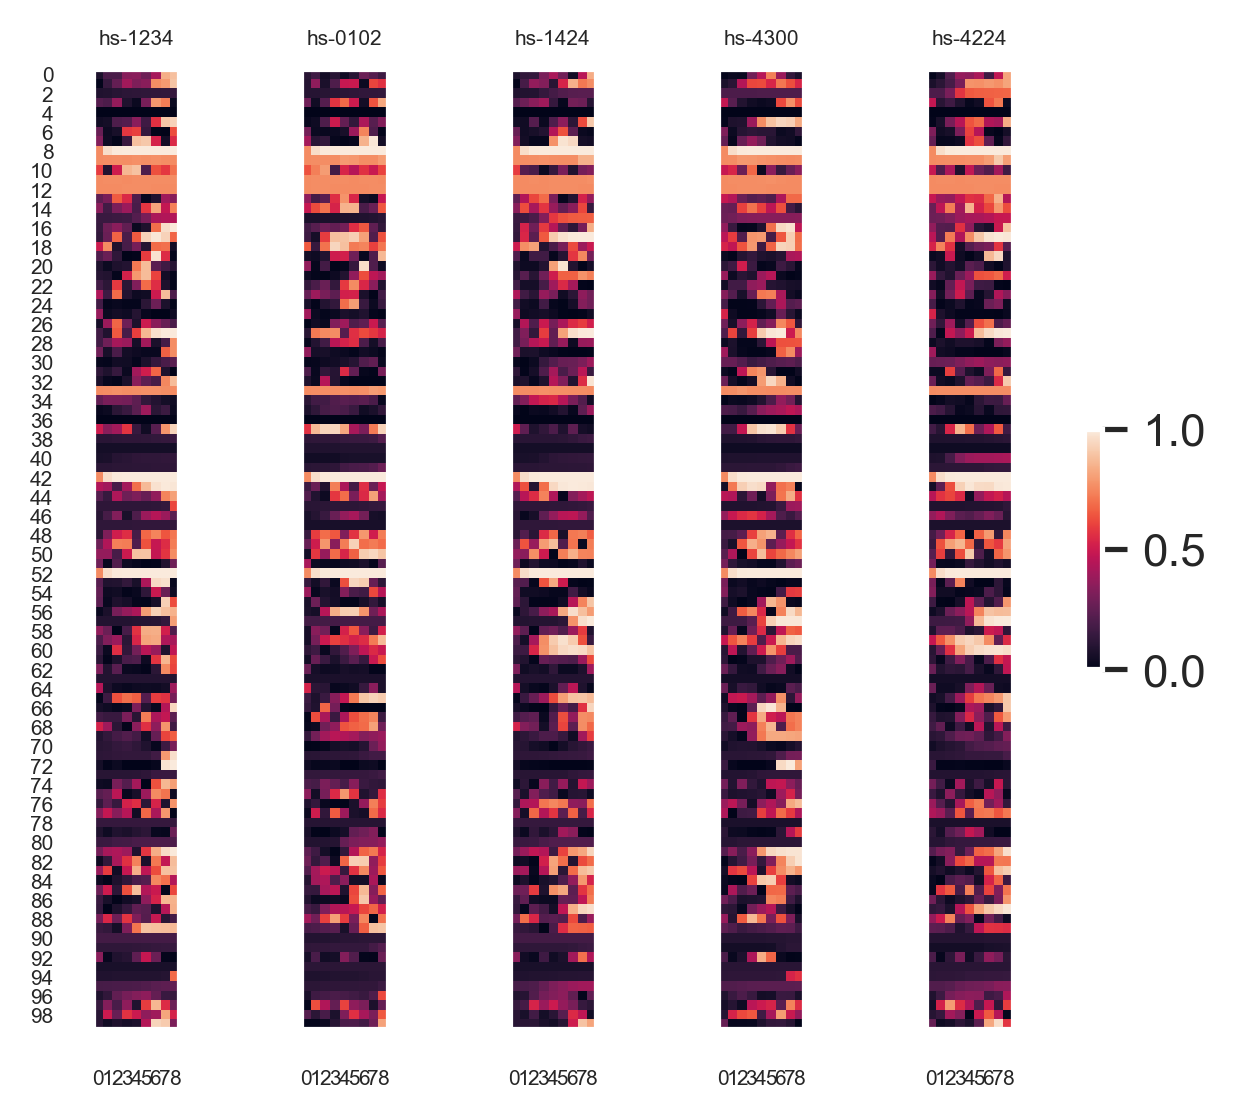

In [260]:
plot_hs_random('hs')

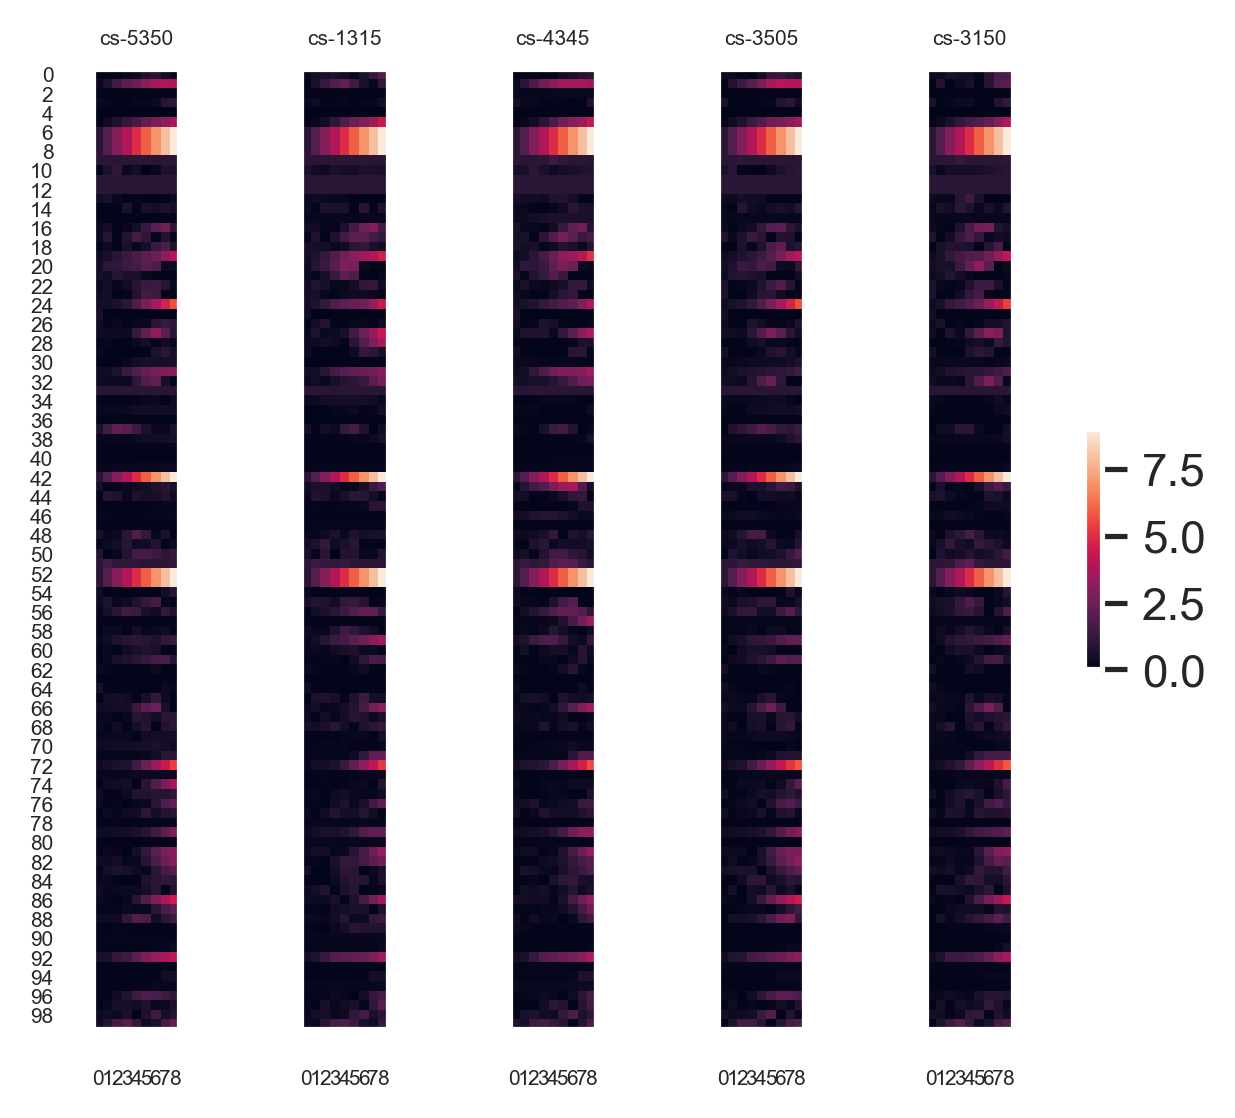

In [261]:
plot_hs_random('cs')

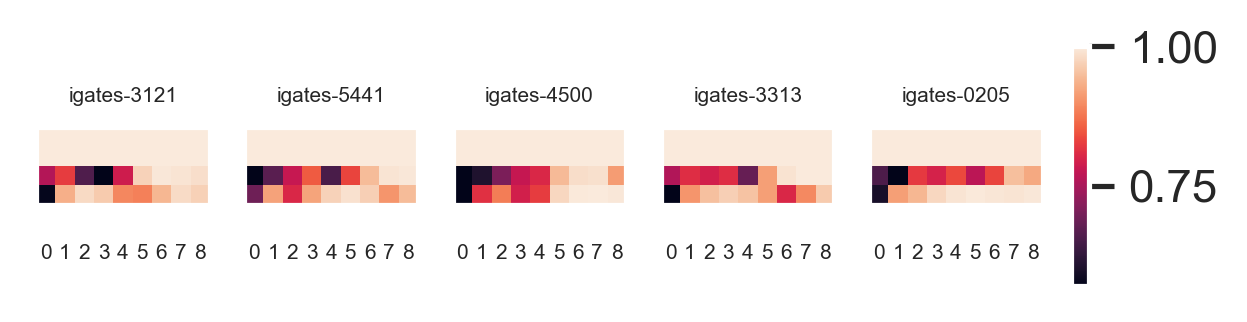

In [192]:
plot_hs_random('igates')

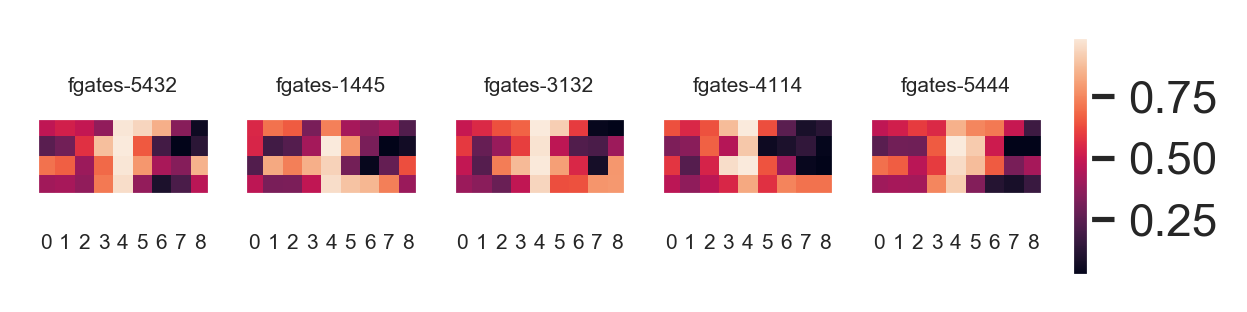

In [193]:
plot_hs_random('fgates')

## ablating cells

In [2]:
mdl = torch.load('lstm-clf-repeat-mky-whole.mdl')

/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [213]:
logs = []
for k in range(100):
    acc_lst = []
    for _ in range(10):
        indices = random.sample(range(100), k=k)
        _, acc = ablation_test(mdl, 200, indices)
        acc_lst.append(acc)
    log = {'k':k, 'acc_mean': np.mean(acc_lst), 'acc_std': np.std(acc_lst)}
    logs.append(log)
    print(log)

{'k': 0, 'acc_mean': 0.9960000000000001, 'acc_std': 0.003905124837953336}
{'k': 1, 'acc_mean': 0.9938750000000001, 'acc_std': 0.002707050978463483}
{'k': 2, 'acc_mean': 0.9786250000000001, 'acc_std': 0.014921146906320598}
{'k': 3, 'acc_mean': 0.985375, 'acc_std': 0.011990230398119988}
{'k': 4, 'acc_mean': 0.9675, 'acc_std': 0.025322914524201184}
{'k': 5, 'acc_mean': 0.9522499999999999, 'acc_std': 0.03386000590667401}
{'k': 6, 'acc_mean': 0.9567499999999999, 'acc_std': 0.024844516497609666}
{'k': 7, 'acc_mean': 0.9297499999999997, 'acc_std': 0.039669730273849846}
{'k': 8, 'acc_mean': 0.9336249999999999, 'acc_std': 0.030513572799657527}
{'k': 9, 'acc_mean': 0.9387500000000001, 'acc_std': 0.025074887836239654}
{'k': 10, 'acc_mean': 0.9021250000000001, 'acc_std': 0.04157091080310846}
{'k': 11, 'acc_mean': 0.915875, 'acc_std': 0.04269093141406027}
{'k': 12, 'acc_mean': 0.882125, 'acc_std': 0.05484366987173635}
{'k': 13, 'acc_mean': 0.81925, 'acc_std': 0.05697916285801331}
{'k': 14, 'acc_mea

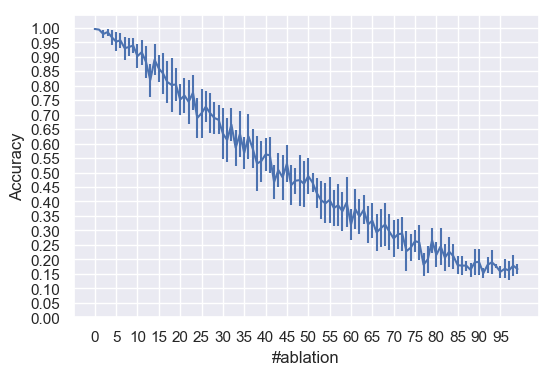

In [229]:
fig, ax = plt.subplots()
fig.dpi = 100
x = [log['k'] for log in logs]
y = [log['acc_mean'] for log in logs]
err = [log['acc_std'] for log in logs]
plt.errorbar(x=x, y=y, yerr=err)
plt.xticks(list(range(0, 100, 5)))
plt.yticks([i * 0.05 for i in range(100 // 5)] + [1])
plt.ylabel('Accuracy')
plt.xlabel('#ablation')
plt.show()

In [210]:
ablation_test(mdl, 200, [6,7,8,24,42,53,72,79,86,92])

([0.99, 0.93, 0.93, 0.935], 0.94625)

In [231]:
ablation_test(mdl, 200, [1, 5, 14, 18, 37, 49, 50, 60, 68, 83, 80])

([0.755, 0.475, 0.475, 0.545], 0.5625)

In [232]:
len([1, 5, 14, 18, 37, 49, 50, 60, 68, 83, 80])

11

In [209]:
ablation_test(mdl, 200, 52)

([0.99, 1.0, 0.99, 0.995], 0.99375)

In [208]:
ablation_test(mdl, 200, [49, 50, 83, 88])

([0.945, 0.78, 0.85, 0.795], 0.8425)

In [256]:
for cidx in range(100):
    acc_along, acc_mean = ablation_test(mdl, 400, cidx)
    if acc_mean <= 0.97:
        print(f'cix {cidx} along {acc_along}, mean {acc_mean}')

cix 49 along [1.0, 0.965, 0.9475, 0.9575], mean 0.9674999999999999
cix 50 along [0.955, 0.9575, 0.97, 0.9375], mean 0.9550000000000001
cix 83 along [0.9875, 0.96, 0.96, 0.9425], mean 0.9624999999999999
cix 88 along [0.9725, 0.9625, 0.9675, 0.9775], mean 0.97


In [245]:
set1 = [49, 50, 83, 88]
ablation_test(mdl, 200, [49, 50, 83, 88])

([0.895, 0.795, 0.84, 0.805], 0.83375)

In [230]:
for cidx in range(100):
    acc_along, acc_mean = ablation_test(mdl, 200, cidx)
    if acc_mean <= 0.98:
        print(f'cix {cidx} along {acc_along}, mean {acc_mean}')

cix 1 along [0.99, 0.98, 0.965, 0.98], mean 0.97875
cix 5 along [1.0, 0.96, 0.965, 0.99], mean 0.97875
cix 14 along [0.99, 0.975, 0.96, 0.95], mean 0.96875
cix 18 along [1.0, 0.975, 0.945, 0.935], mean 0.96375
cix 37 along [0.995, 0.955, 0.965, 0.99], mean 0.9762500000000001
cix 49 along [1.0, 0.975, 0.945, 0.975], mean 0.97375
cix 50 along [0.935, 0.945, 0.96, 0.935], mean 0.94375
cix 60 along [0.975, 0.97, 0.98, 0.99], mean 0.97875
cix 68 along [1.0, 0.98, 0.96, 0.96], mean 0.975
cix 83 along [0.995, 0.965, 0.965, 0.965], mean 0.9724999999999999
cix 88 along [0.99, 0.965, 0.945, 0.98], mean 0.97


In [382]:
set2 = [1, 14, 18, 37, 49, 50, 60, 68, 88]
ablation_test(mdl, 200, set2)

([0.725, 0.56, 0.5, 0.49], 0.5687500000000001)

In [383]:
set2 = [1, 5, 14, 18, 37, 49, 50, 60, 68, 83, 88]
ablation_test(mdl, 200, set2)

([0.785, 0.47, 0.46, 0.625], 0.585)

In [255]:
len(set2)

11

In [233]:
for cidx in range(100):
    acc_along, acc_mean = ablation_test(mdl, 200, cidx)
    if acc_mean < 0.99:
        print(f'cix {cidx} along {acc_along}, mean {acc_mean}')

cix 1 along [0.99, 0.99, 0.955, 0.99], mean 0.98125
cix 5 along [0.985, 0.96, 0.955, 0.975], mean 0.96875
cix 10 along [1.0, 0.99, 0.97, 0.98], mean 0.985
cix 14 along [0.99, 0.99, 0.975, 0.975], mean 0.9825
cix 18 along [0.99, 0.97, 0.97, 0.945], mean 0.9687499999999999
cix 22 along [0.995, 1.0, 0.965, 0.995], mean 0.98875
cix 26 along [1.0, 0.99, 0.97, 0.975], mean 0.98375
cix 37 along [0.99, 0.965, 0.99, 0.97], mean 0.97875
cix 48 along [1.0, 0.99, 0.965, 0.98], mean 0.98375
cix 49 along [0.995, 0.97, 0.955, 0.95], mean 0.9675
cix 50 along [0.96, 0.895, 0.965, 0.98], mean 0.95
cix 56 along [0.995, 0.99, 0.98, 0.99], mean 0.98875
cix 59 along [0.98, 0.98, 0.985, 0.965], mean 0.9774999999999999
cix 65 along [0.995, 0.98, 0.99, 0.99], mean 0.98875
cix 72 along [1.0, 0.98, 0.985, 0.99], mean 0.98875
cix 81 along [1.0, 1.0, 0.985, 0.95], mean 0.9837499999999999
cix 83 along [0.985, 0.955, 0.965, 0.965], mean 0.9674999999999999
cix 85 along [1.0, 0.99, 0.975, 0.99], mean 0.98875
cix 88 al

In [248]:
set3 = [1, 5, 10, 14, 18, 22, 26, 37, 48, 49, 50, 56, 59, 60, 65, 68, 83, 80, 85, 88, 97]
ablation_test(mdl, 200, set3)

([0.44, 0.265, 0.345, 0.44], 0.3725)

In [249]:
ablation_test(mdl, 200, list(set(set3) - set(set2)))

([0.875, 0.71, 0.79, 0.64], 0.75375)

In [4]:
for cidx in range(100):
    acc_along, acc_mean = ablation_test(mdl, 200, cidx)
    print(f'along {acc_along}, mean {acc_mean}')

along [1.0, 1.0, 0.995, 0.99], mean 0.9962500000000001
along [0.96, 0.99, 0.97, 0.97], mean 0.9724999999999999
along [1.0, 0.995, 1.0, 1.0], mean 0.99875
along [1.0, 1.0, 0.985, 0.995], mean 0.995
along [1.0, 1.0, 0.995, 1.0], mean 0.99875
along [0.995, 0.97, 0.98, 0.99], mean 0.9837499999999999
along [1.0, 1.0, 0.99, 1.0], mean 0.9975
along [1.0, 1.0, 0.995, 1.0], mean 0.99875
along [1.0, 0.985, 1.0, 0.995], mean 0.995
along [1.0, 1.0, 0.985, 0.995], mean 0.995
along [1.0, 0.99, 0.98, 1.0], mean 0.9924999999999999
along [0.995, 1.0, 0.985, 0.99], mean 0.9924999999999999
along [1.0, 1.0, 0.995, 0.99], mean 0.9962500000000001
along [1.0, 0.995, 1.0, 0.99], mean 0.9962500000000001
along [0.99, 0.985, 0.95, 0.965], mean 0.9724999999999999
along [1.0, 0.995, 0.995, 0.99], mean 0.9950000000000001
along [1.0, 1.0, 0.995, 0.995], mean 0.9975
along [1.0, 0.98, 0.99, 0.985], mean 0.9887499999999999
along [1.0, 0.97, 0.965, 0.94], mean 0.96875
along [0.995, 0.995, 1.0, 0.985], mean 0.99375
along

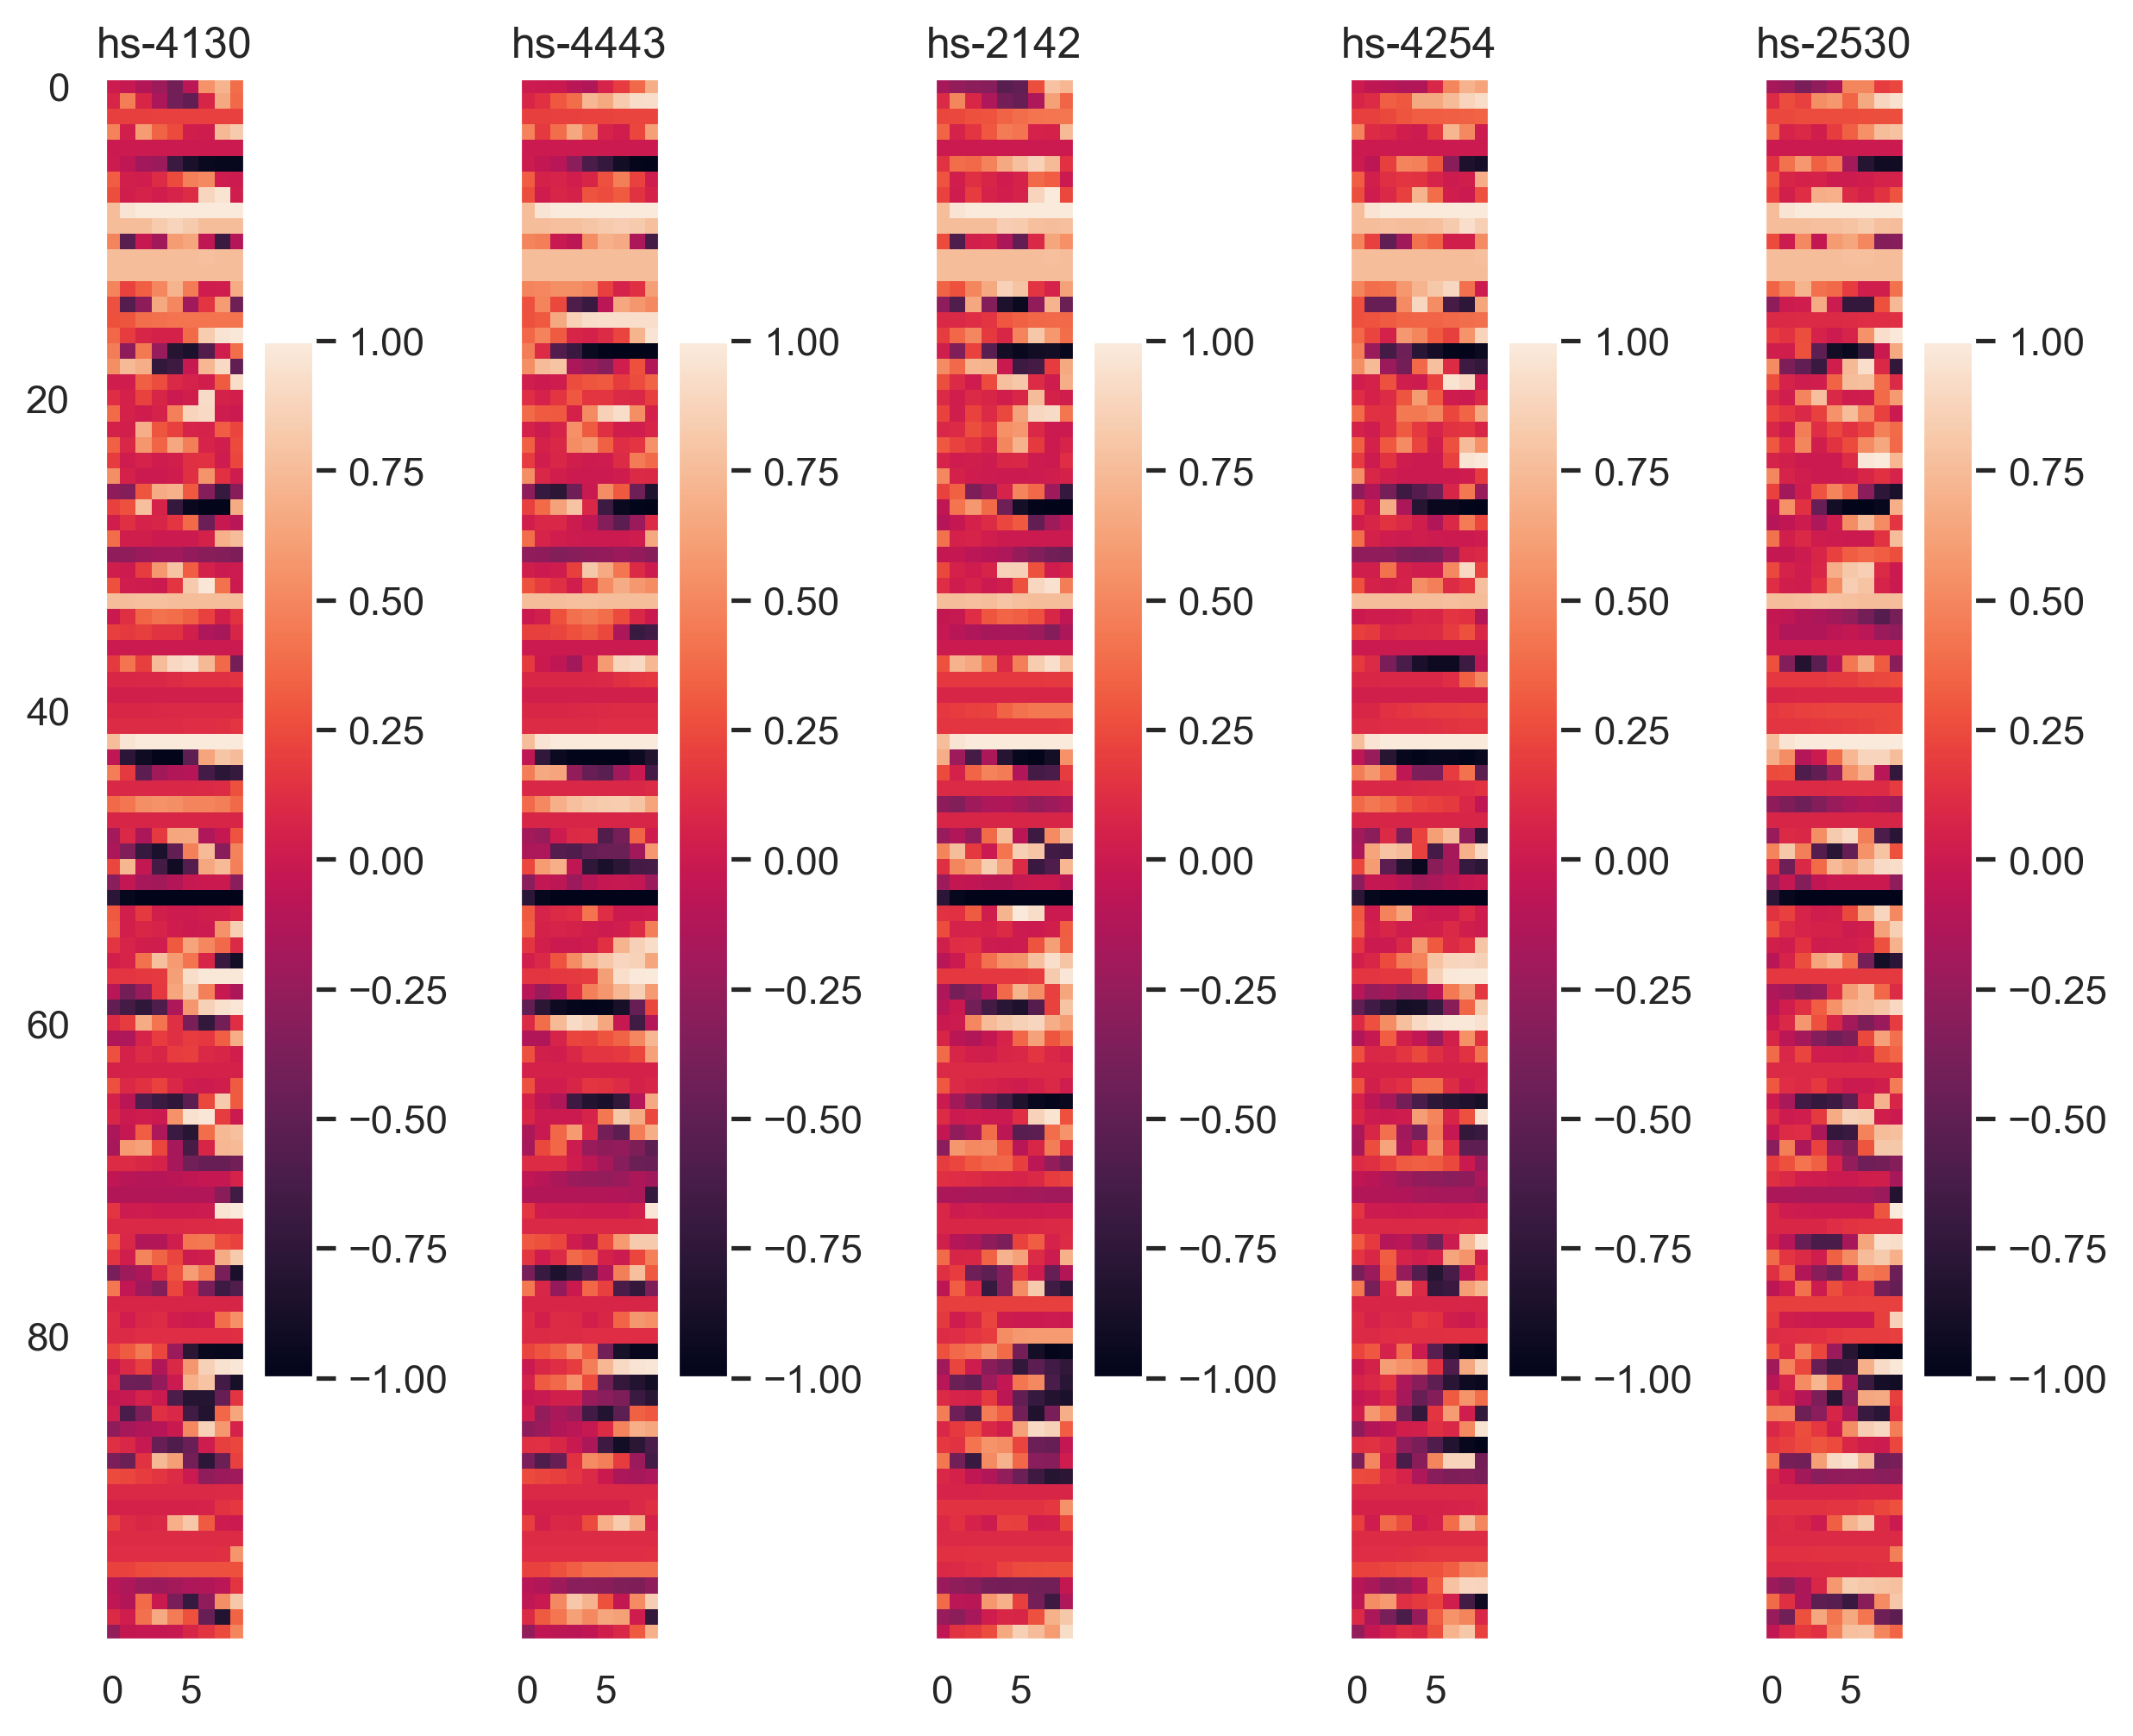

In [202]:
plot_hs_random('hs')

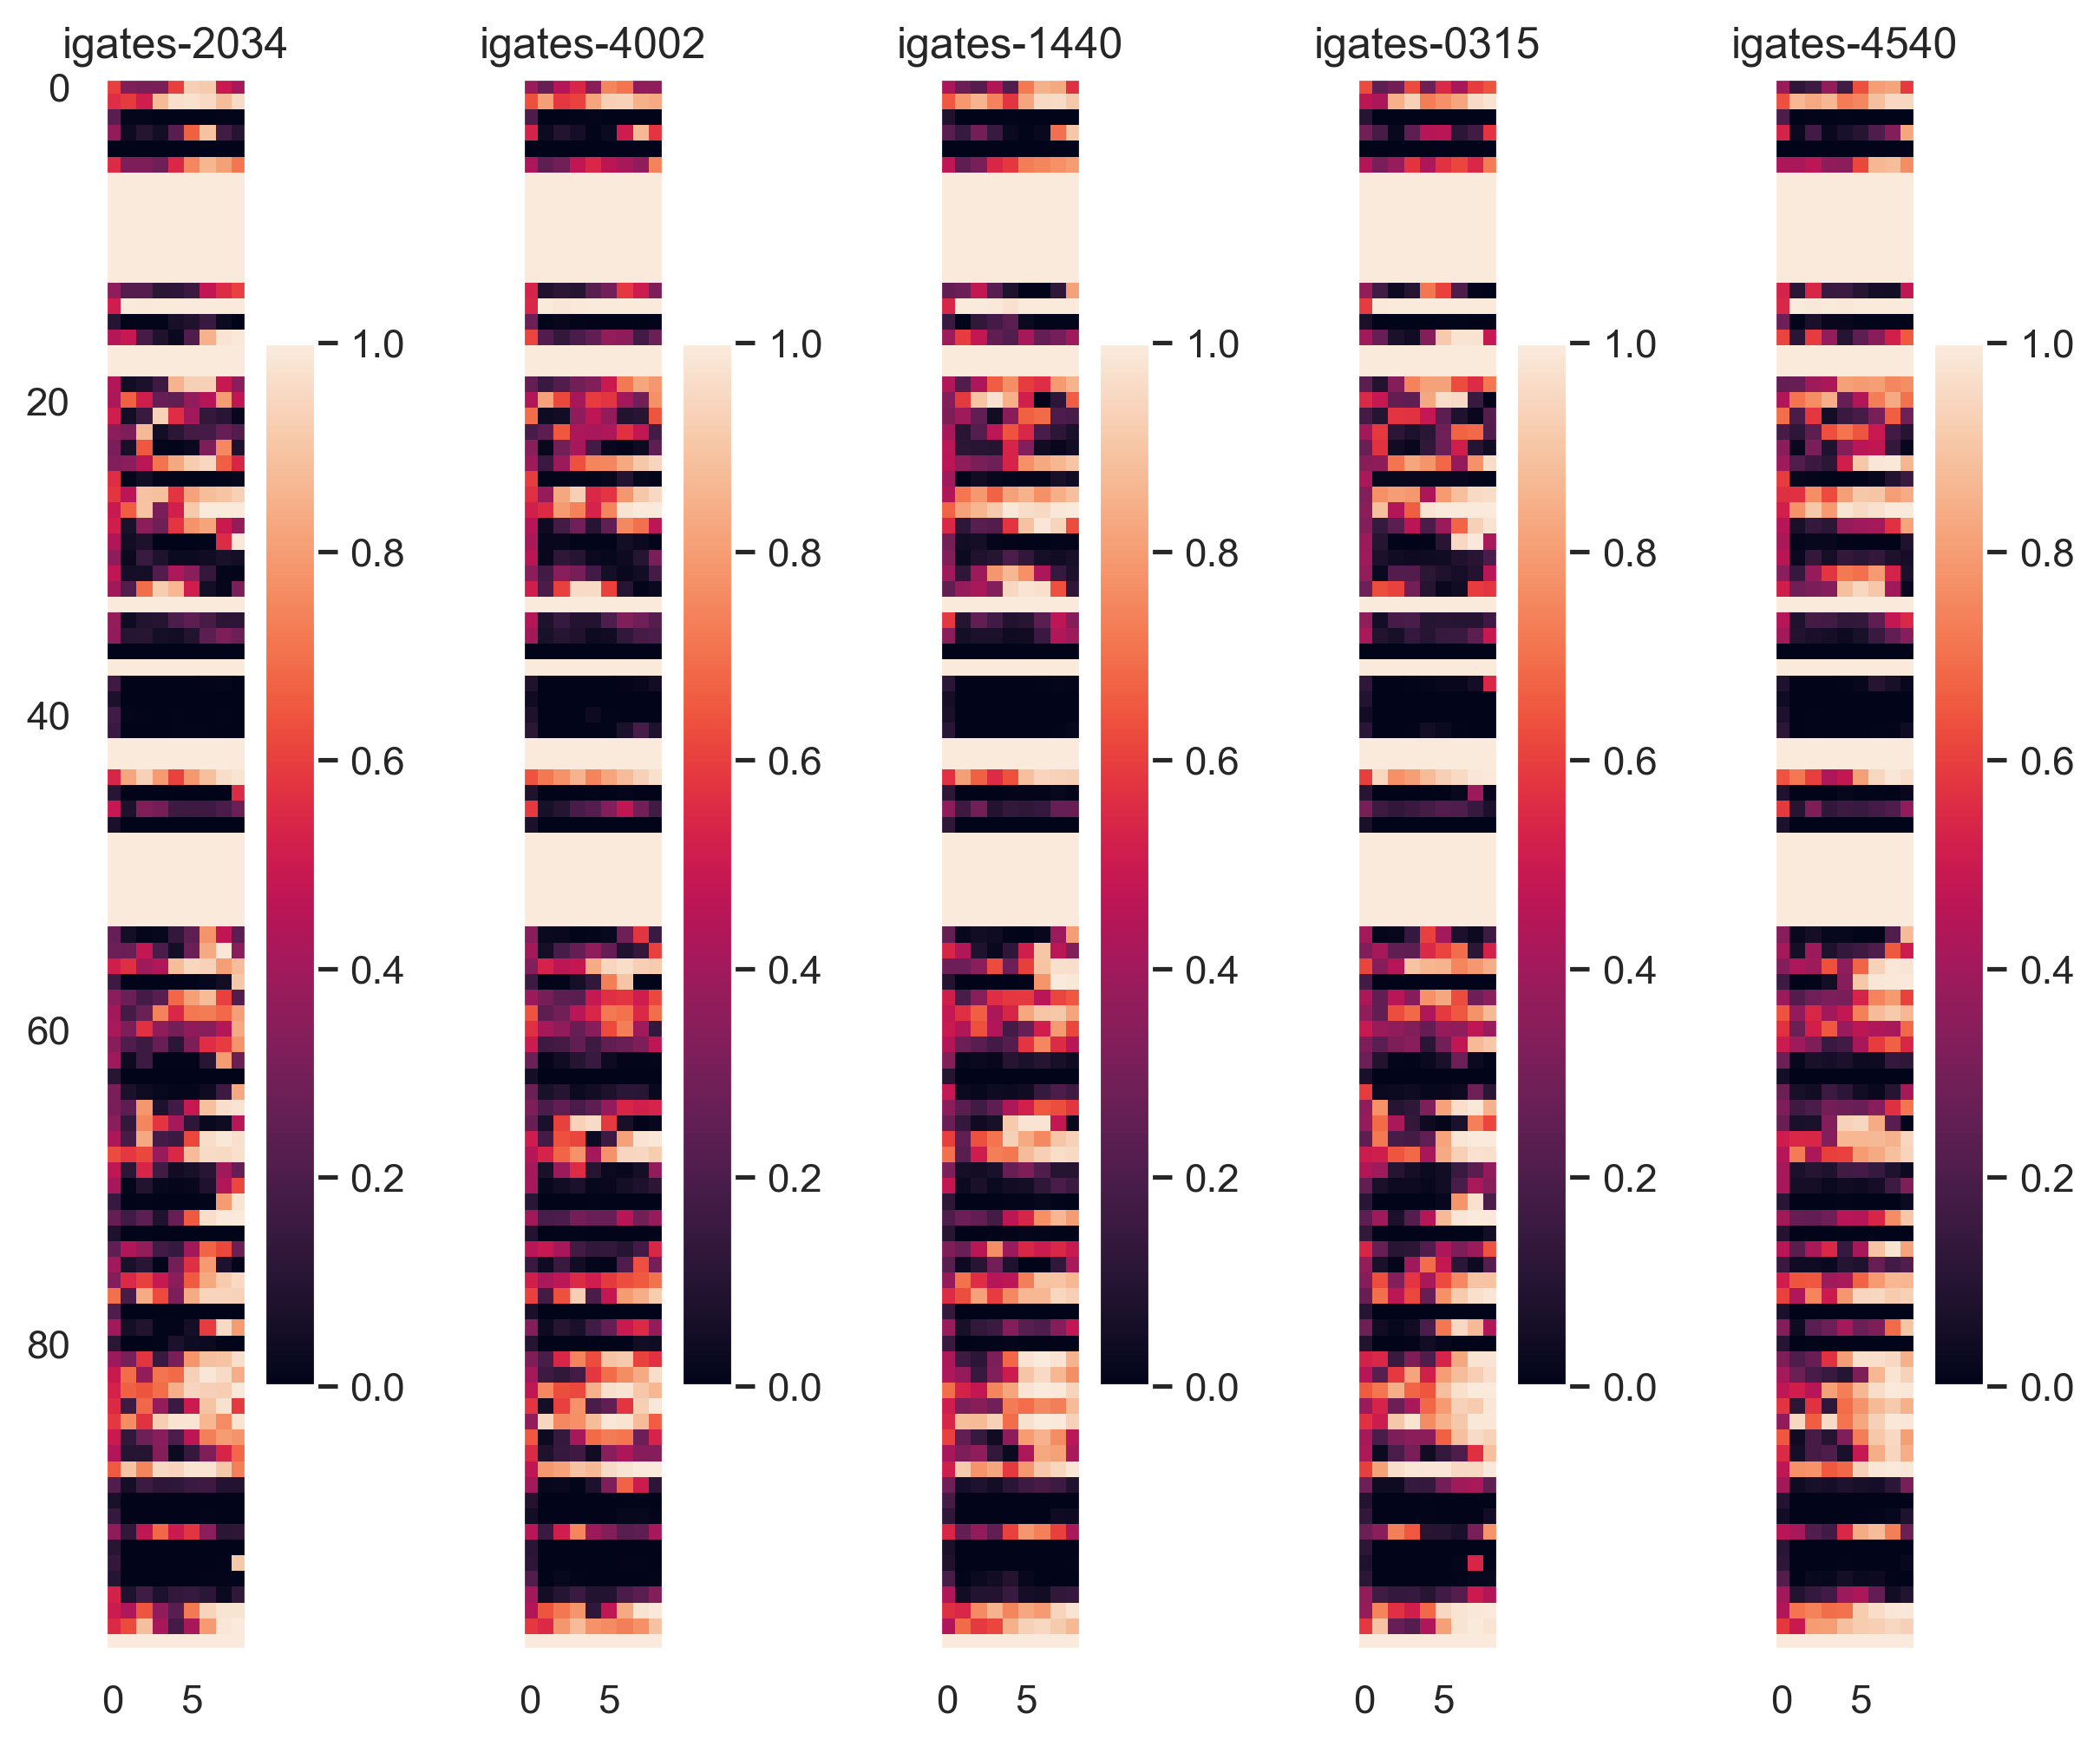

In [203]:
plot_hs_random('igates')

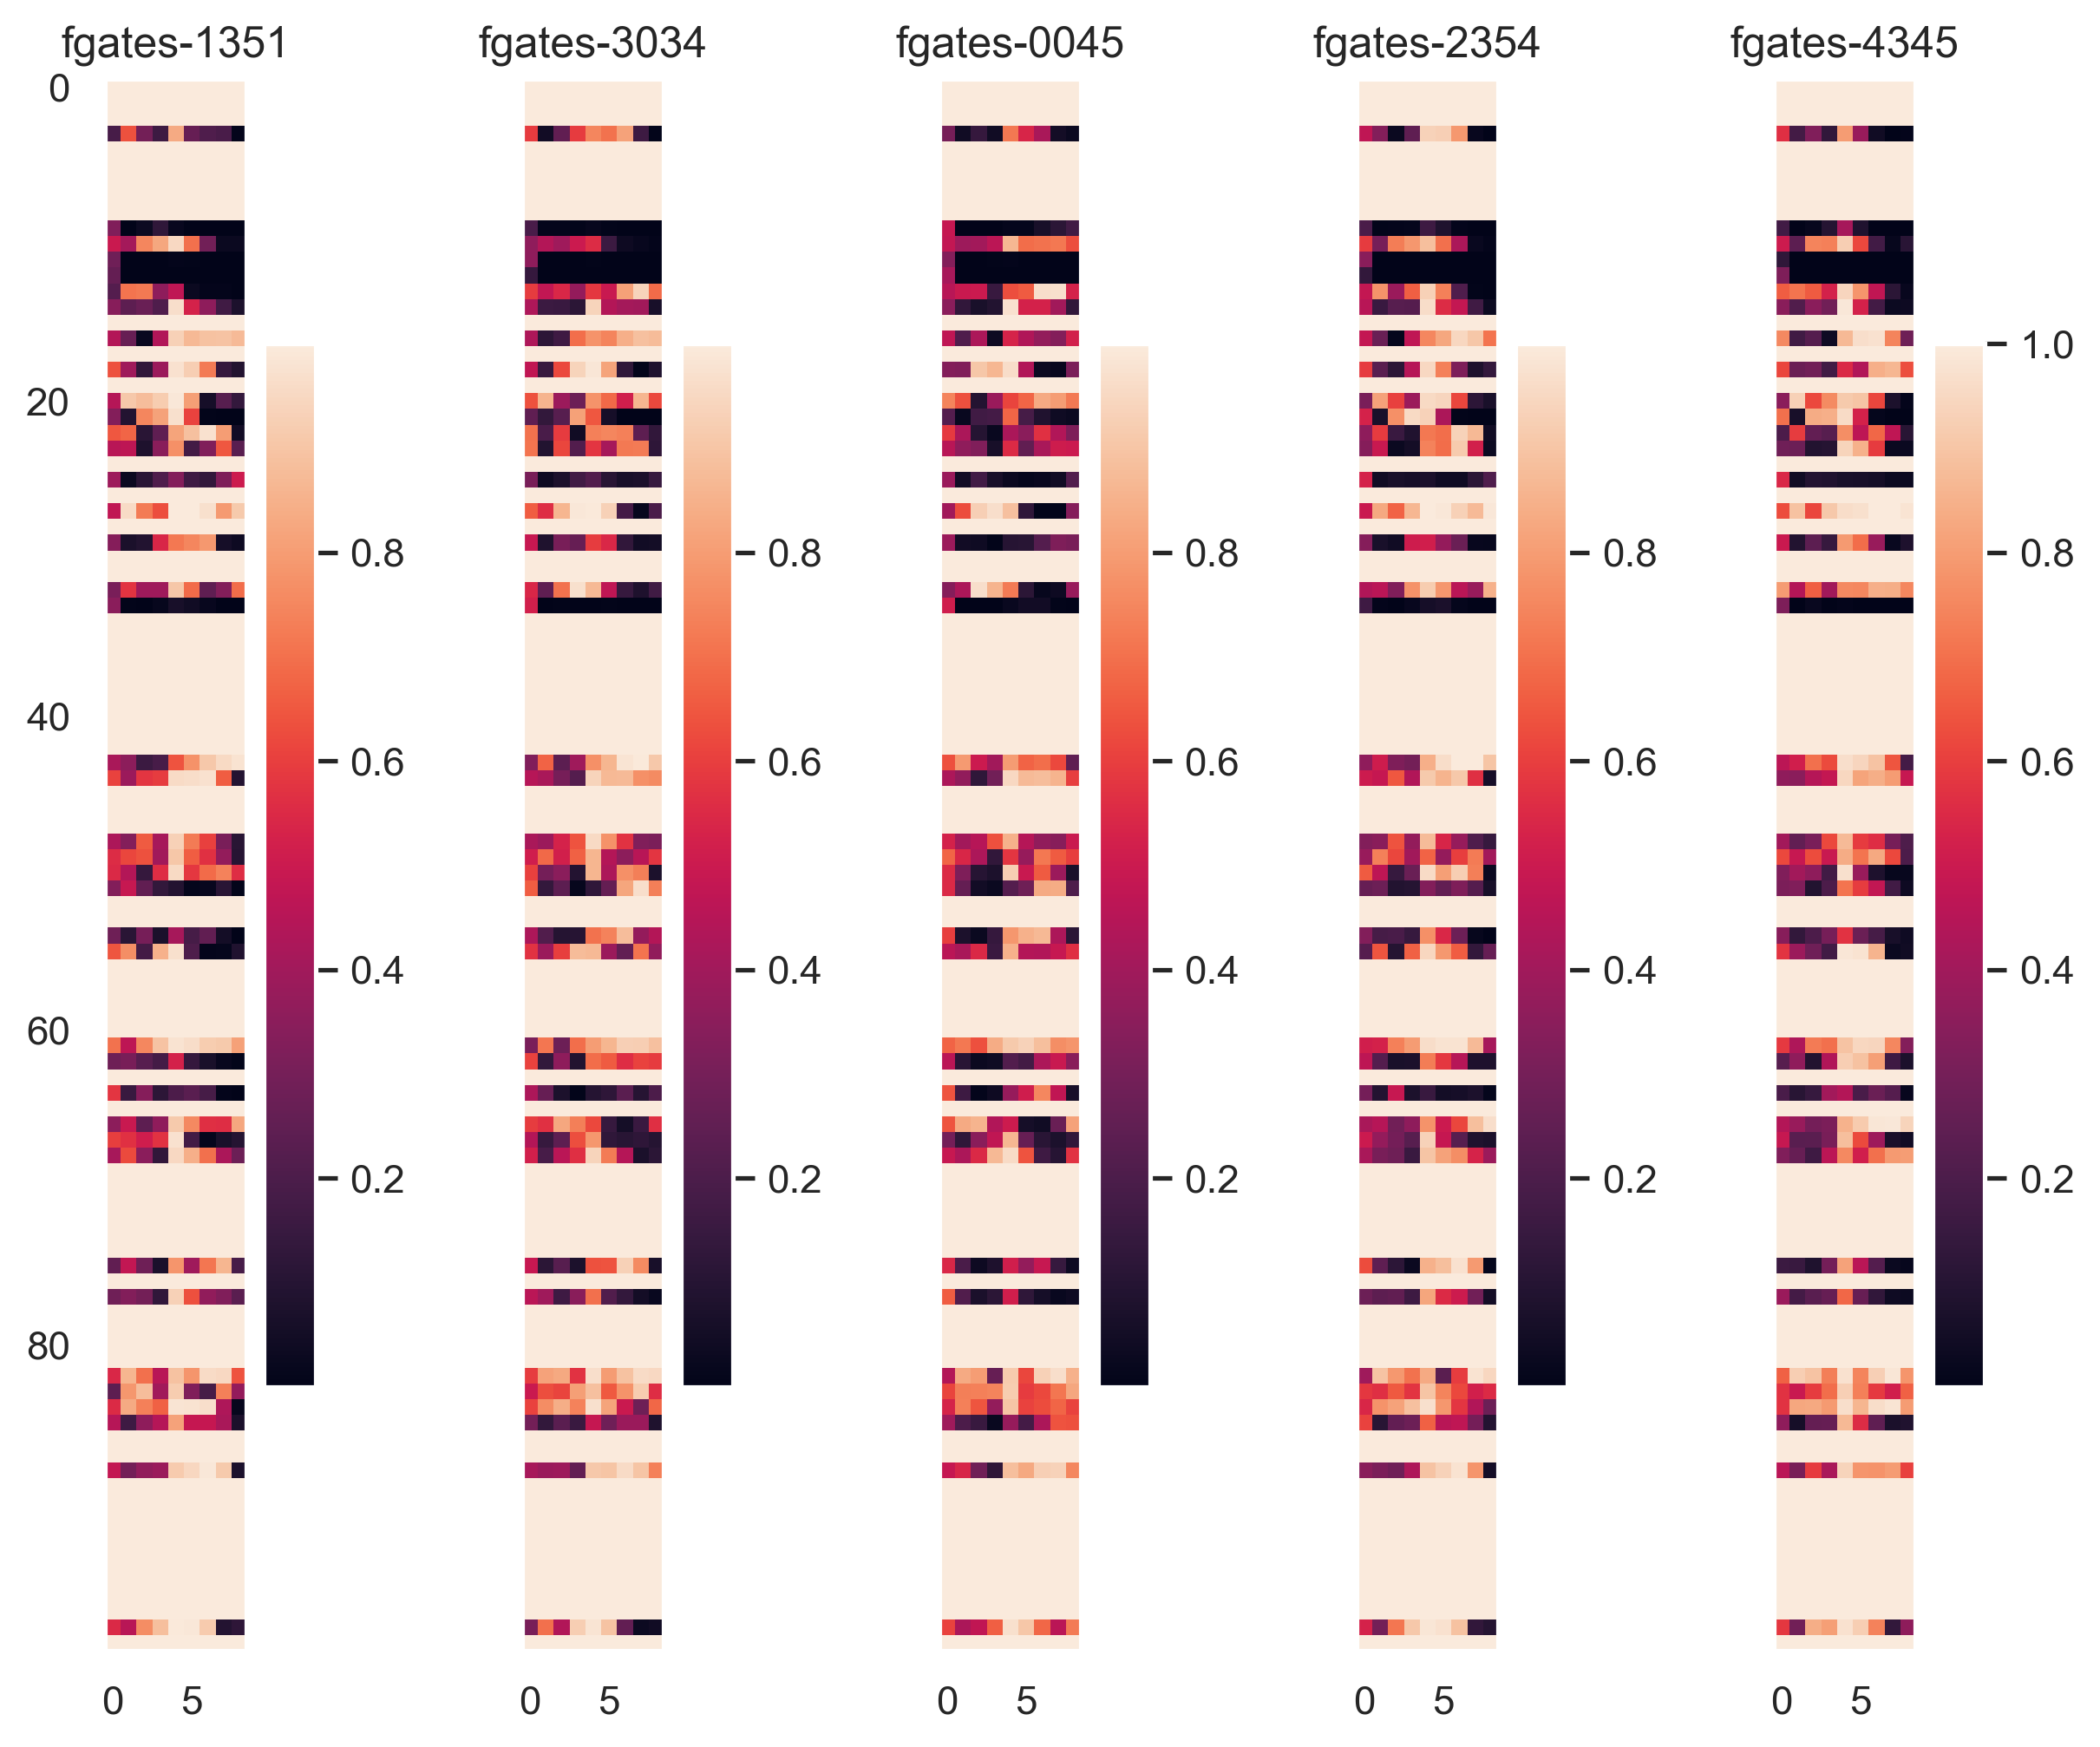

In [204]:
plot_hs_random('fgates')

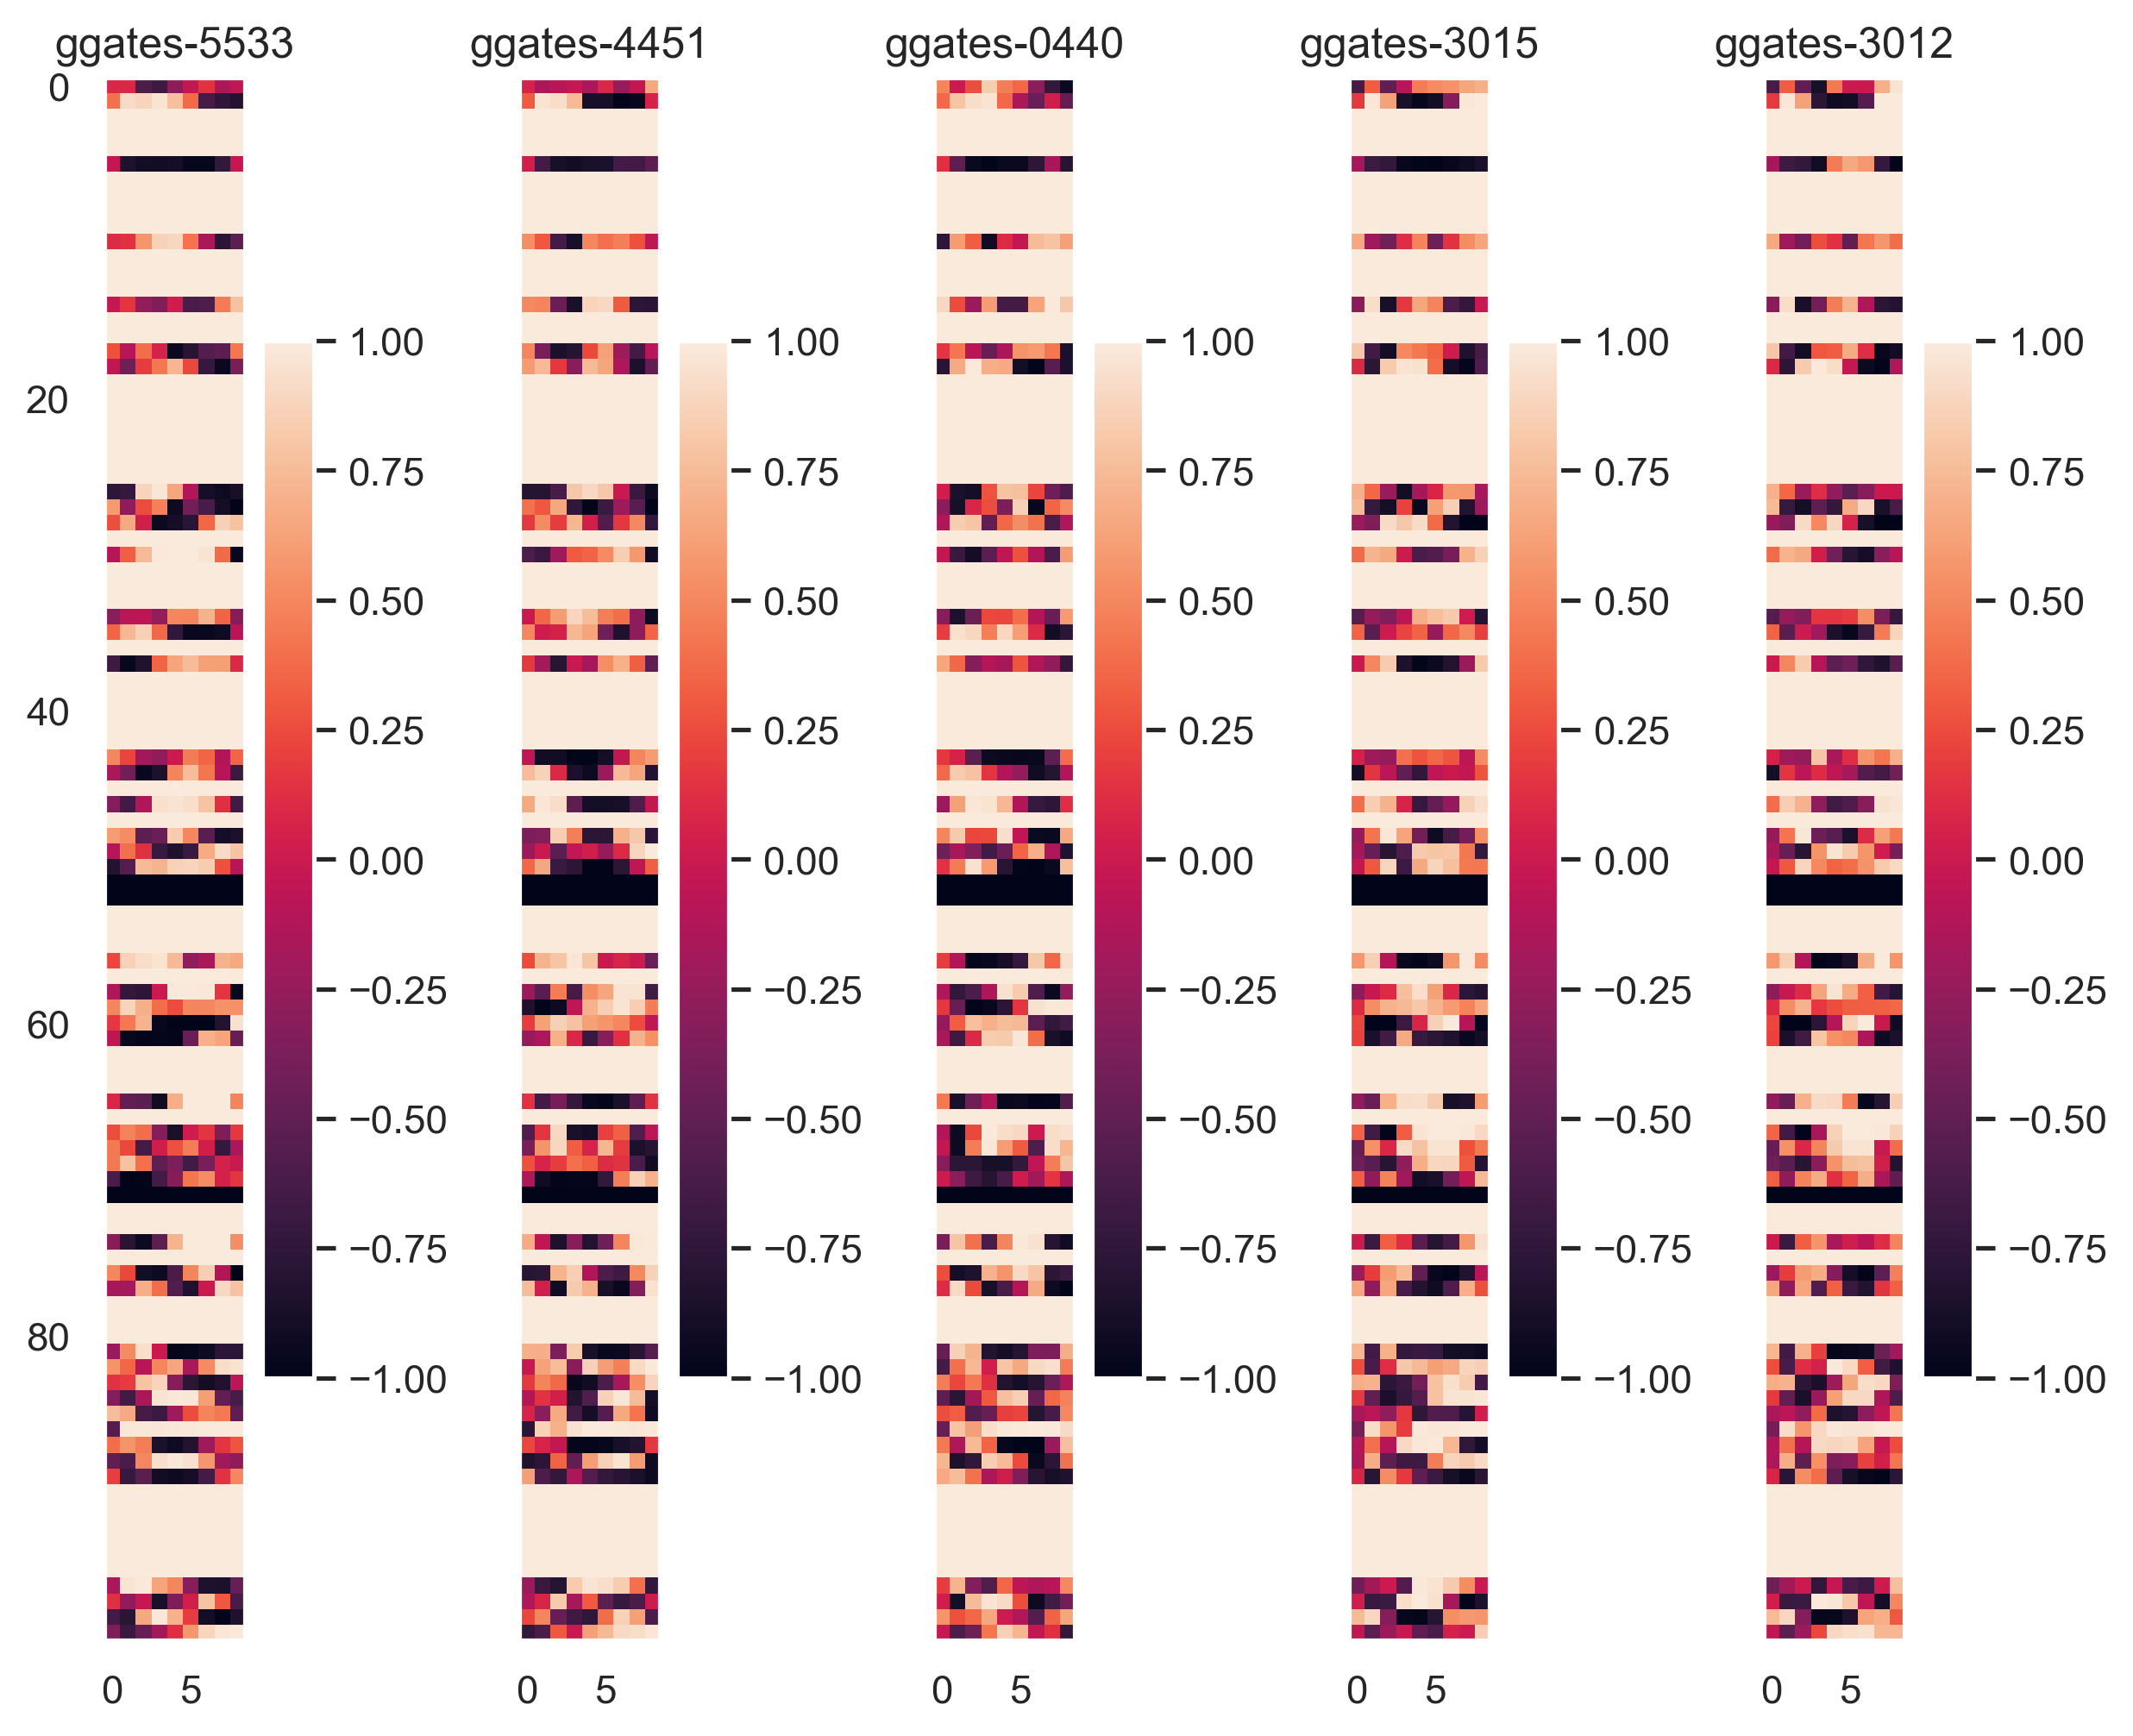

In [205]:
plot_hs_random('ggates')

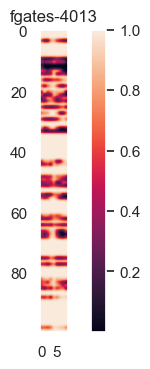

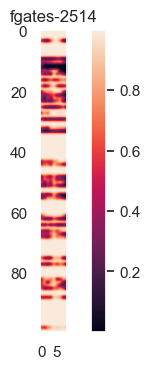

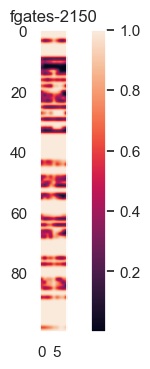

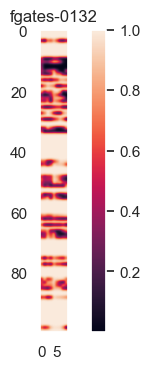

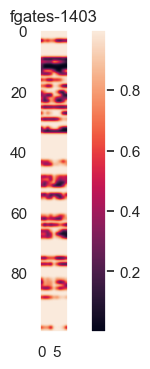

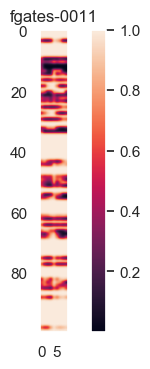

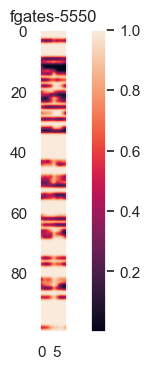

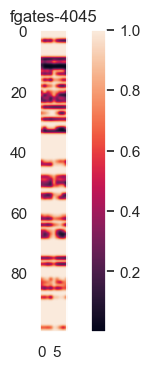

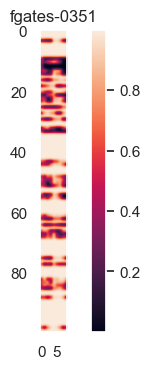

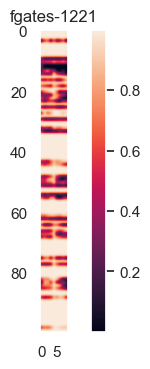

In [75]:
indices = random.sample(list(range(len(name_lst))), k=10)
for idx in indices:
    x0, x1, x2, x3 = map(int, list(name_lst[idx]))
    plot_hs(x0, x1, x2, x3, 'fgates')

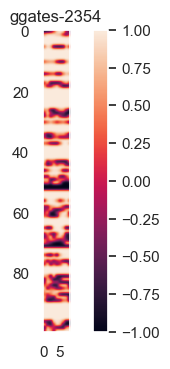

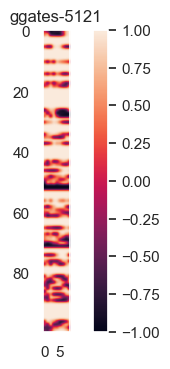

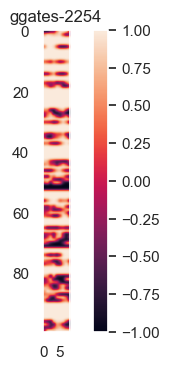

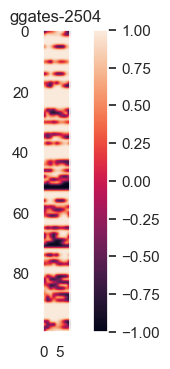

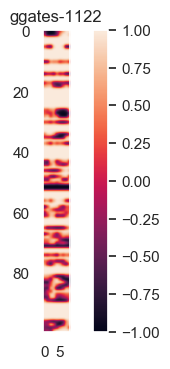

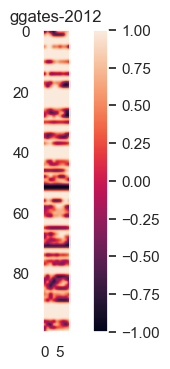

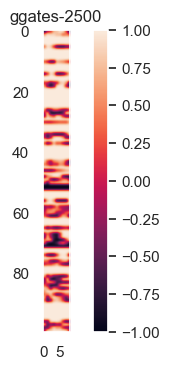

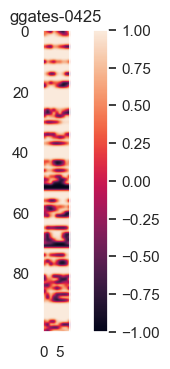

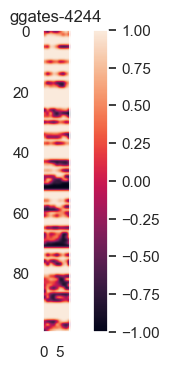

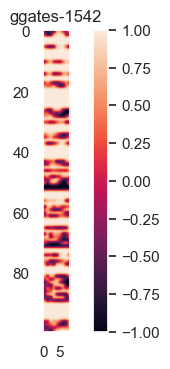

In [71]:
indices = random.sample(list(range(len(name_lst))), k=10)
for idx in indices:
    x0, x1, x2, x3 = map(int, list(name_lst[idx]))
    plot_hs(x0, x1, x2, x3, 'ggates')

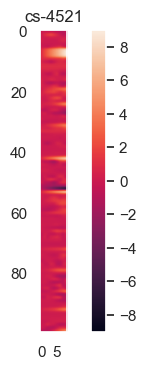

In [67]:

plot_hs(4, 5, 2, 1, 'cs')

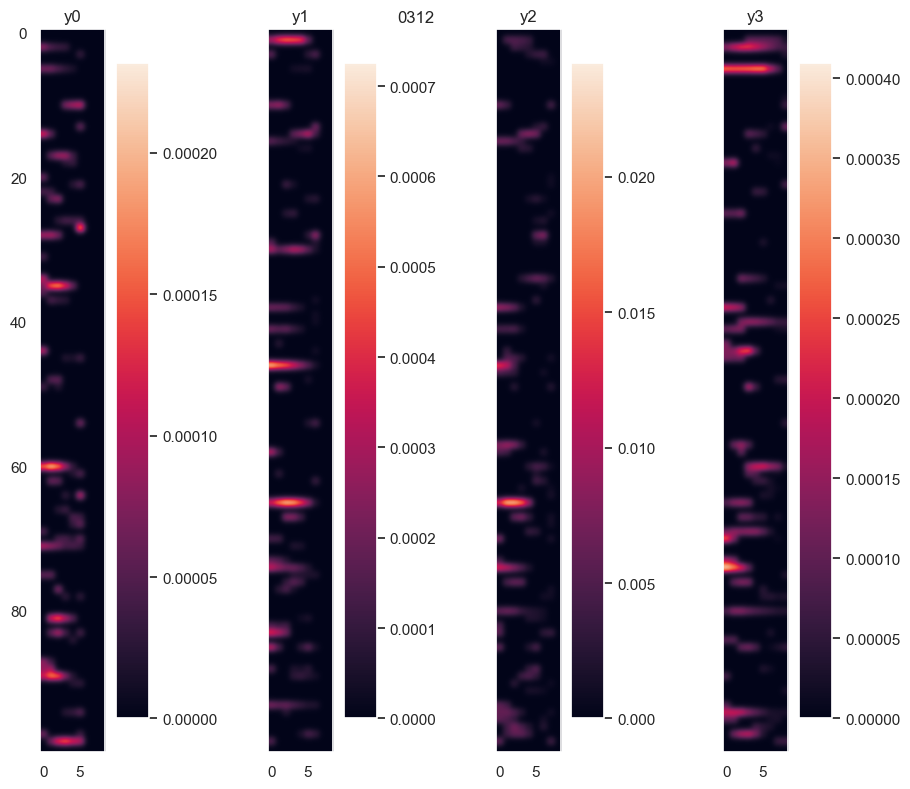

In [410]:
grad_tar2hs(0,3,1,2, k=20, title='0312')

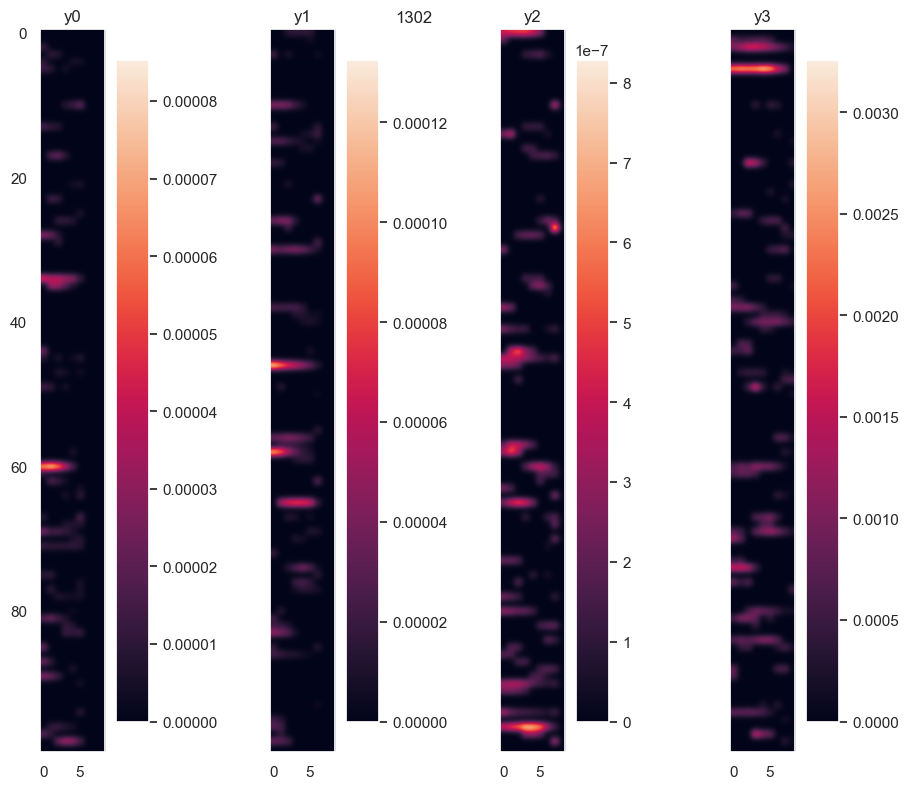

In [412]:
grad_tar2hs(1,3,0,2, k=20, title='1302')

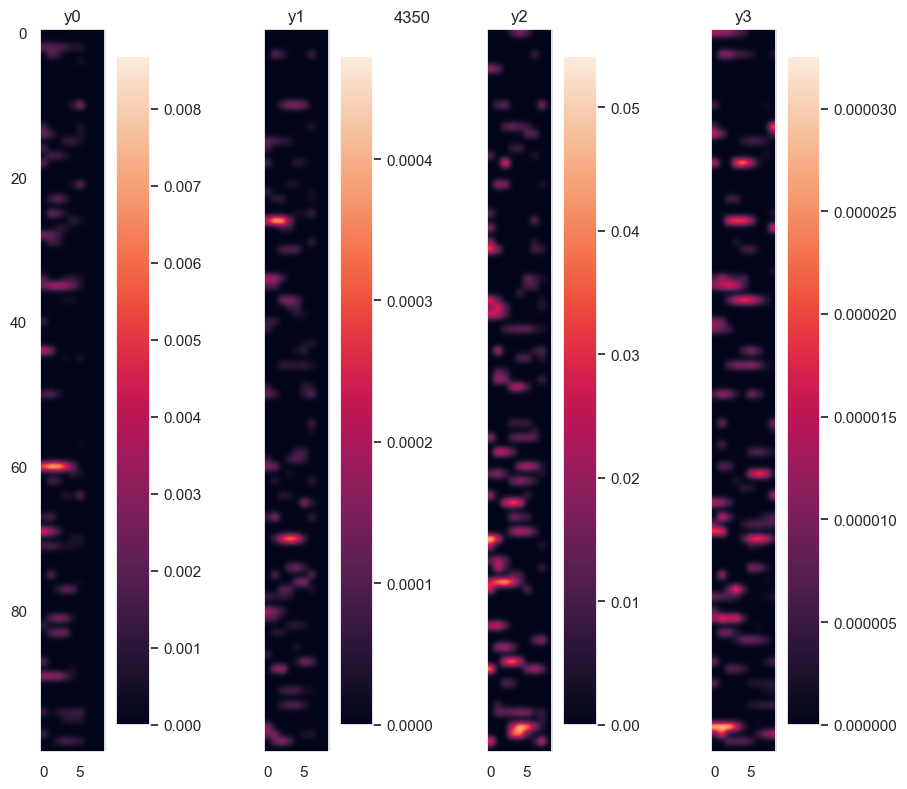

In [414]:
grad_tar2hs(4,3,5,0, k=20, title='4350')

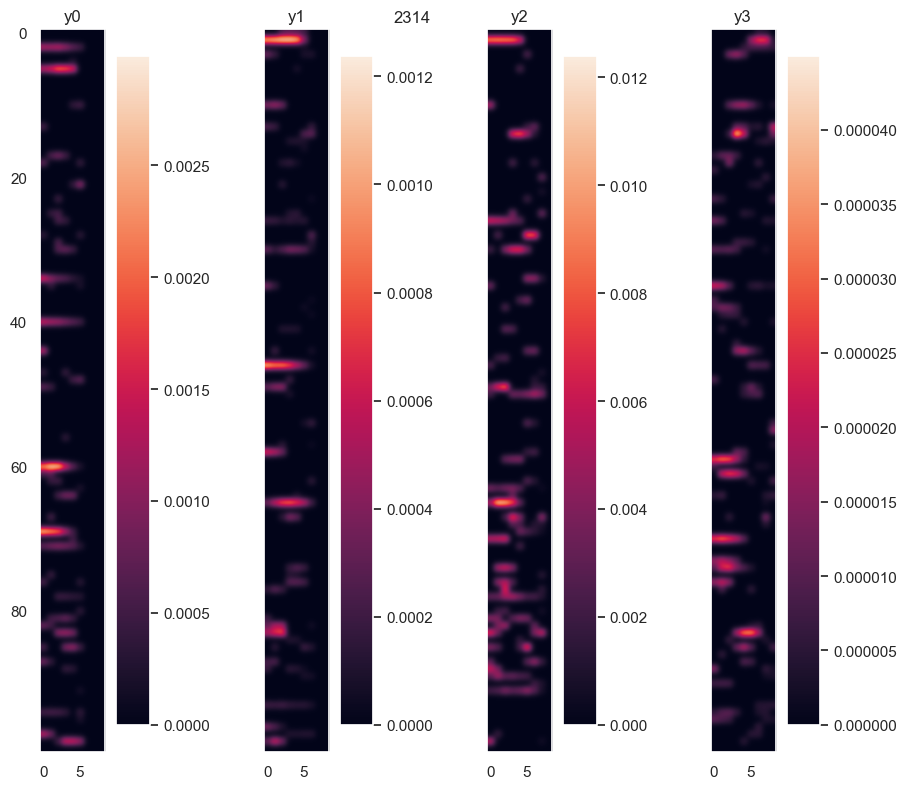

In [416]:
grad_tar2hs(2,3,1,4, k=20, title='2314')

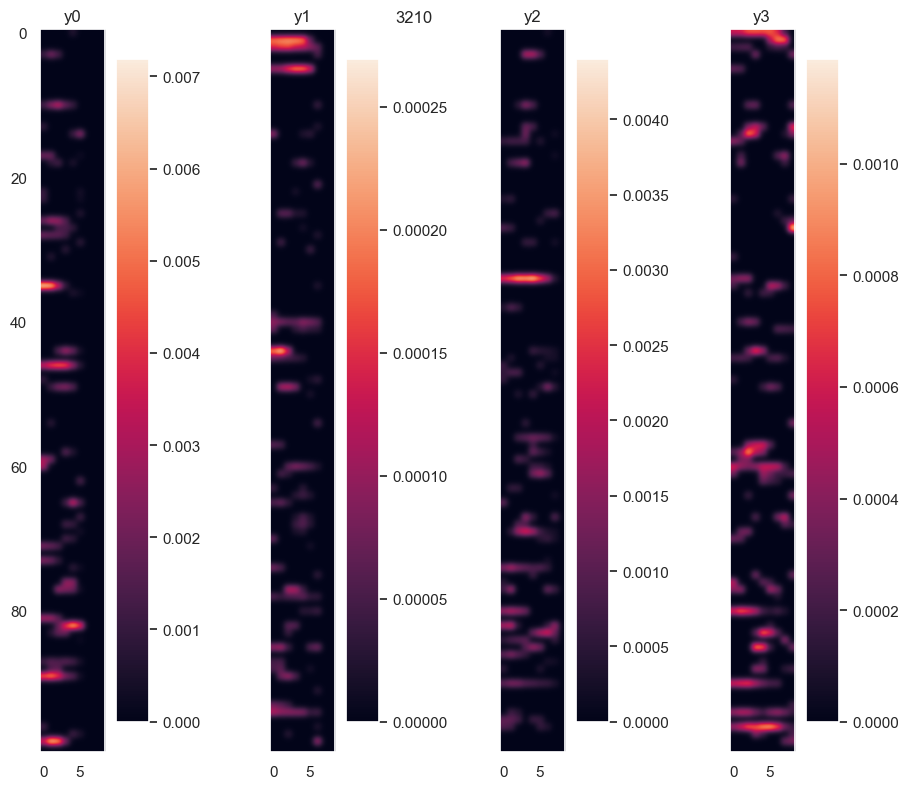

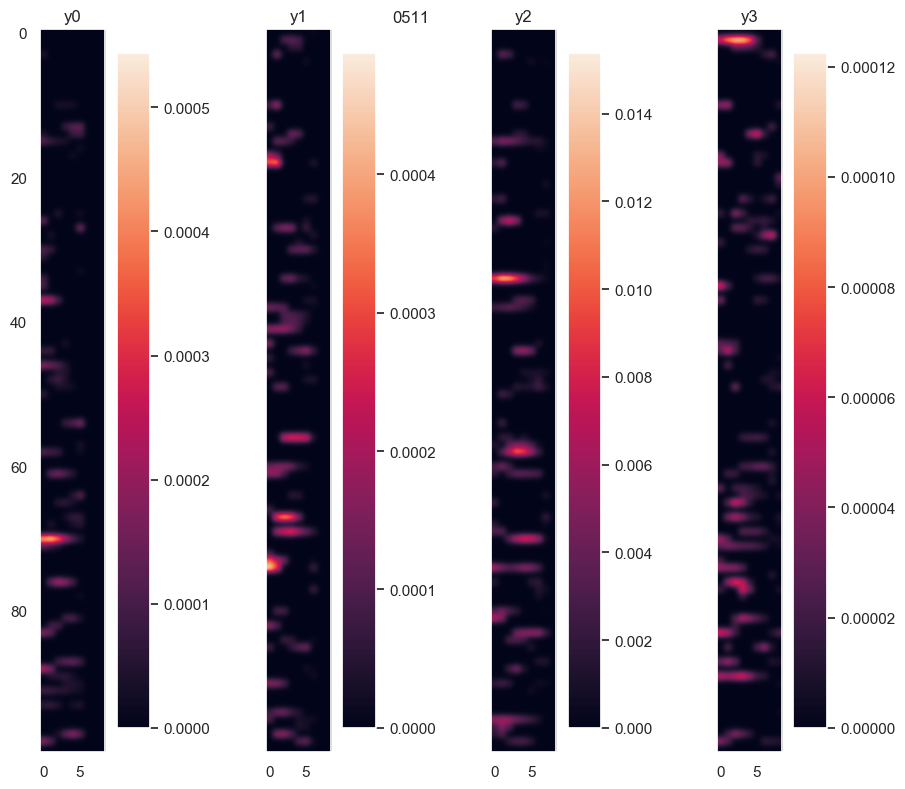

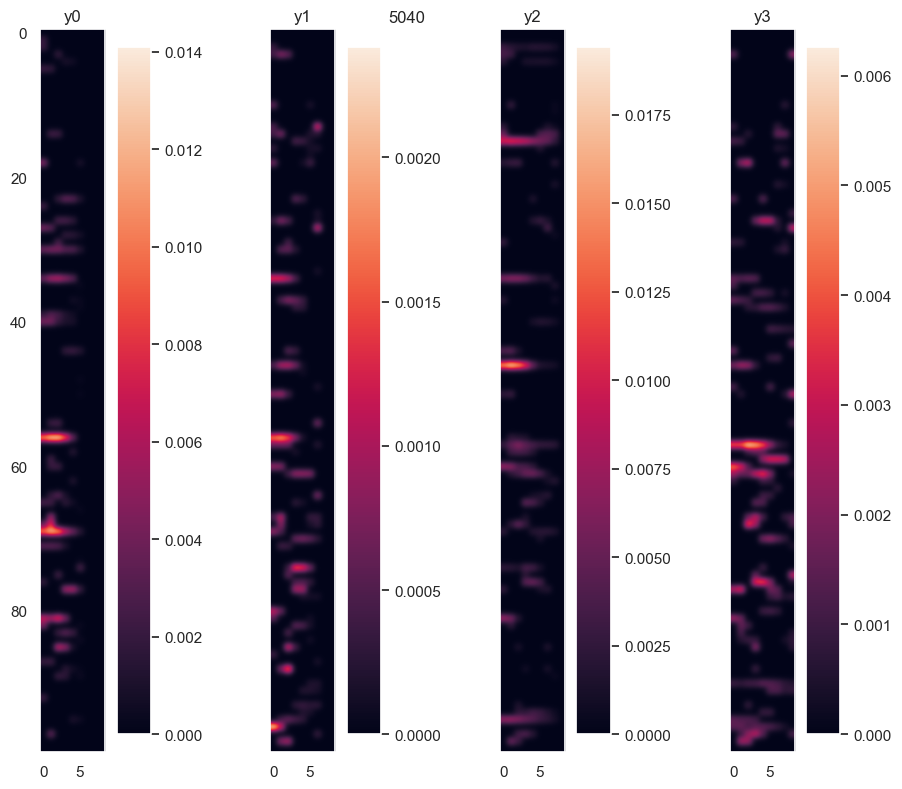

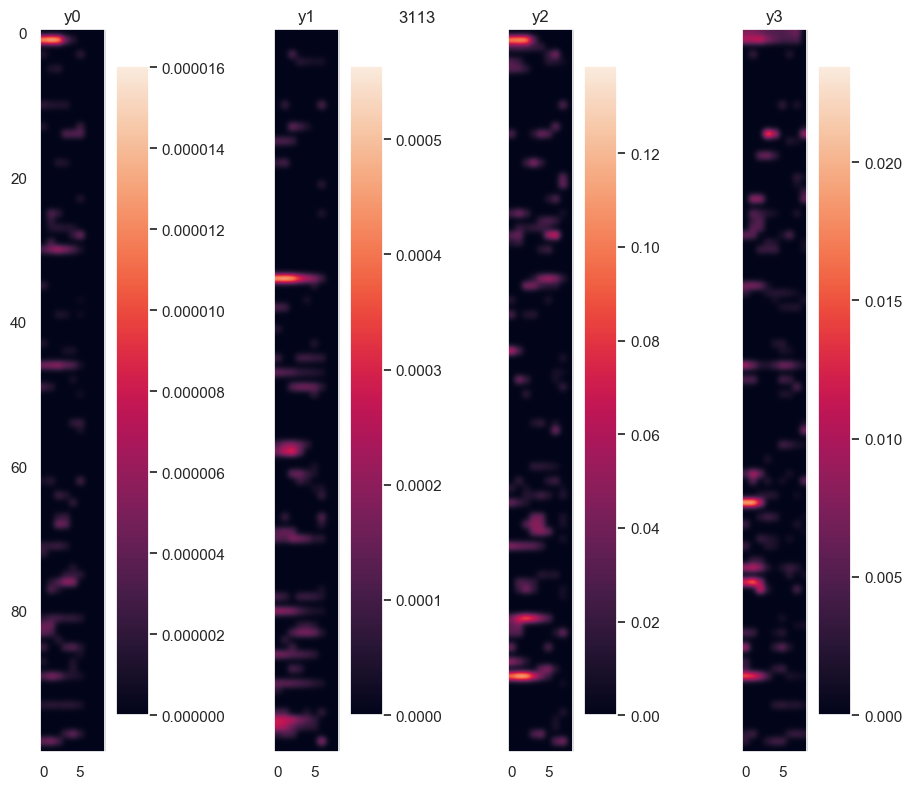

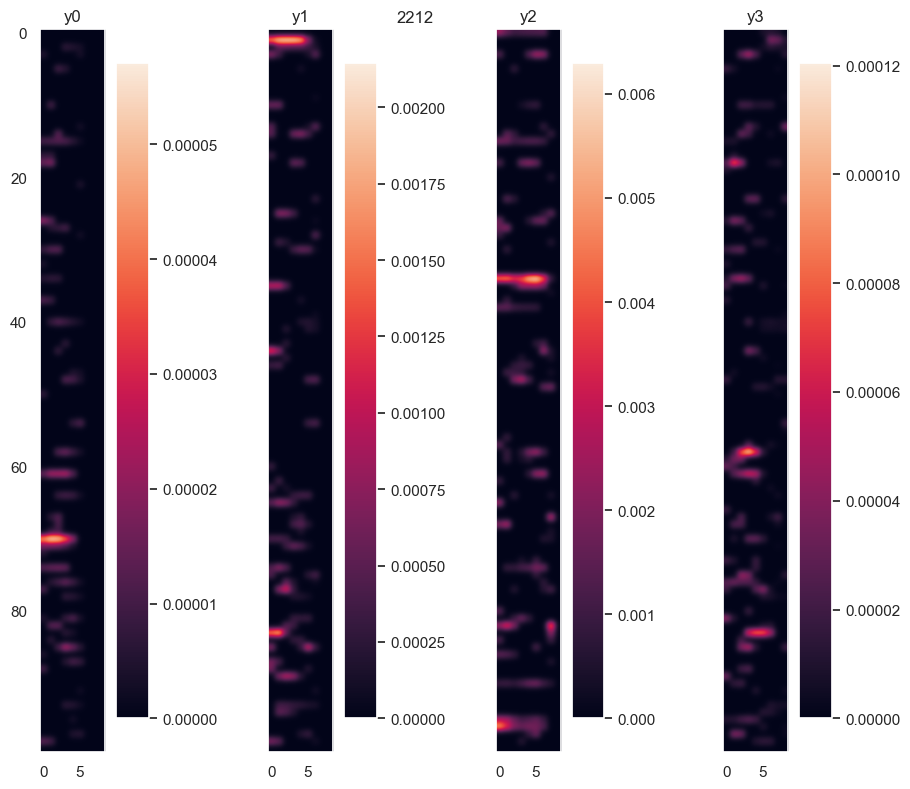

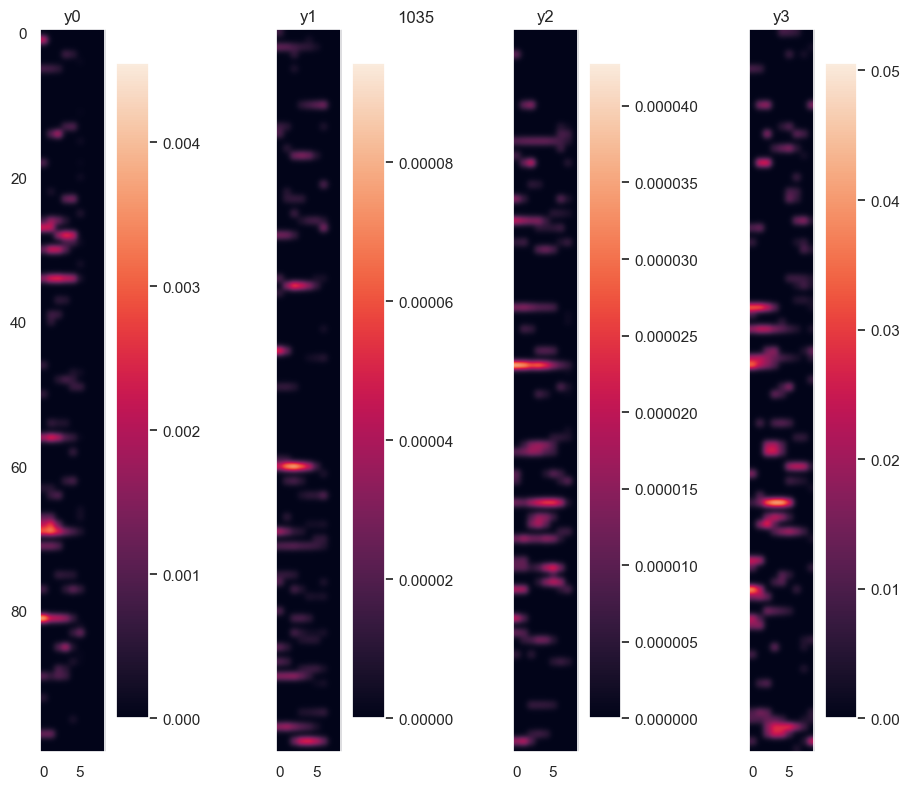

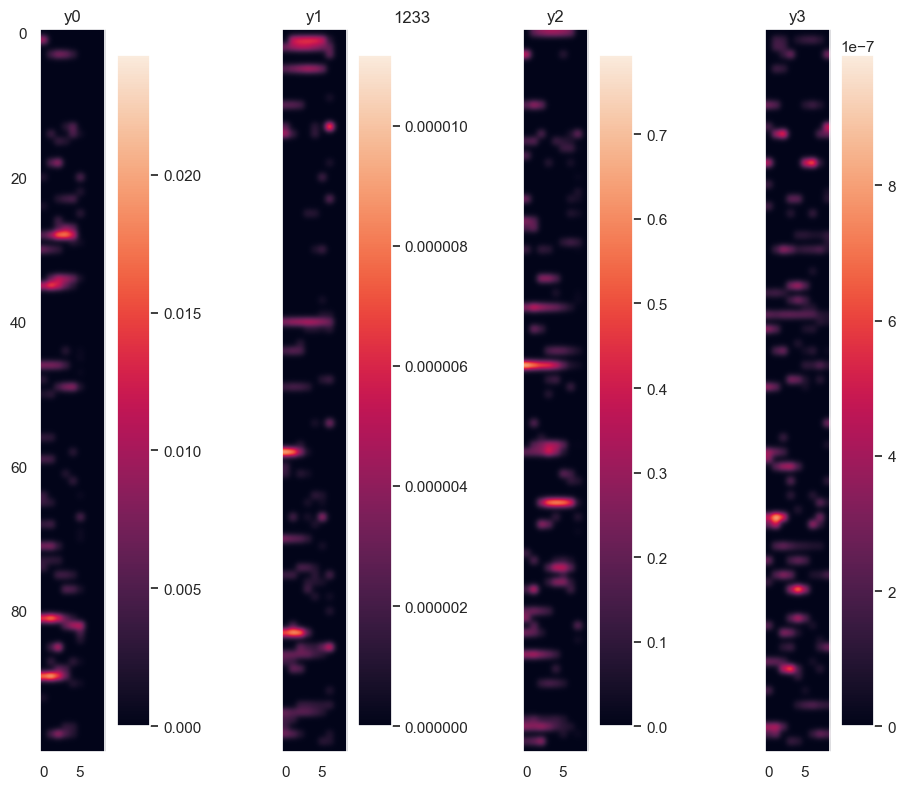

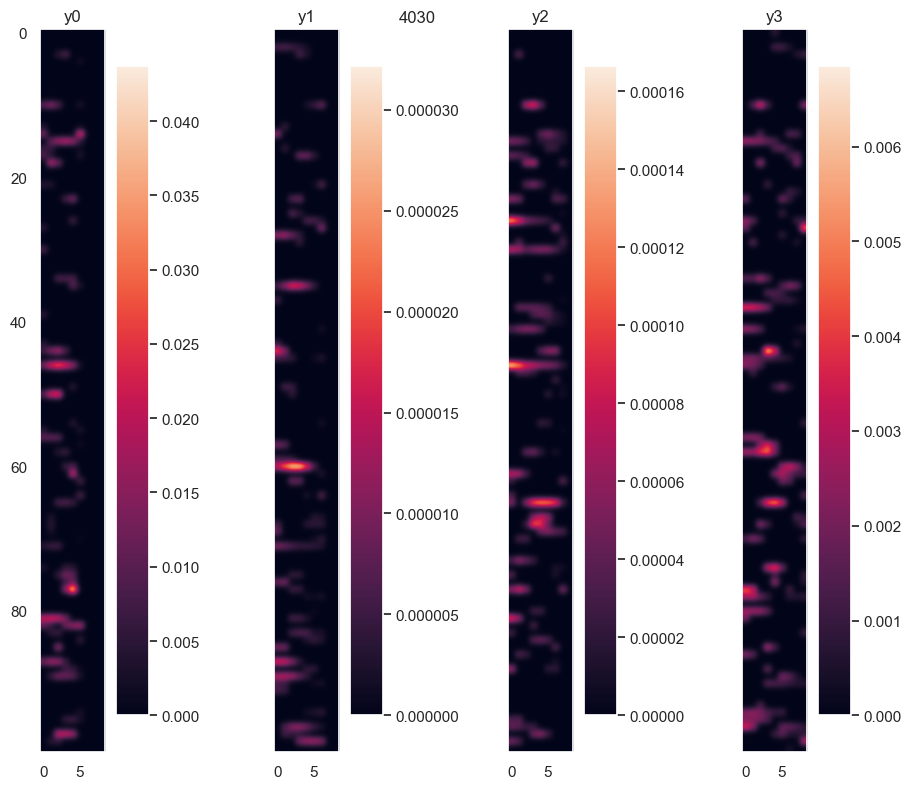

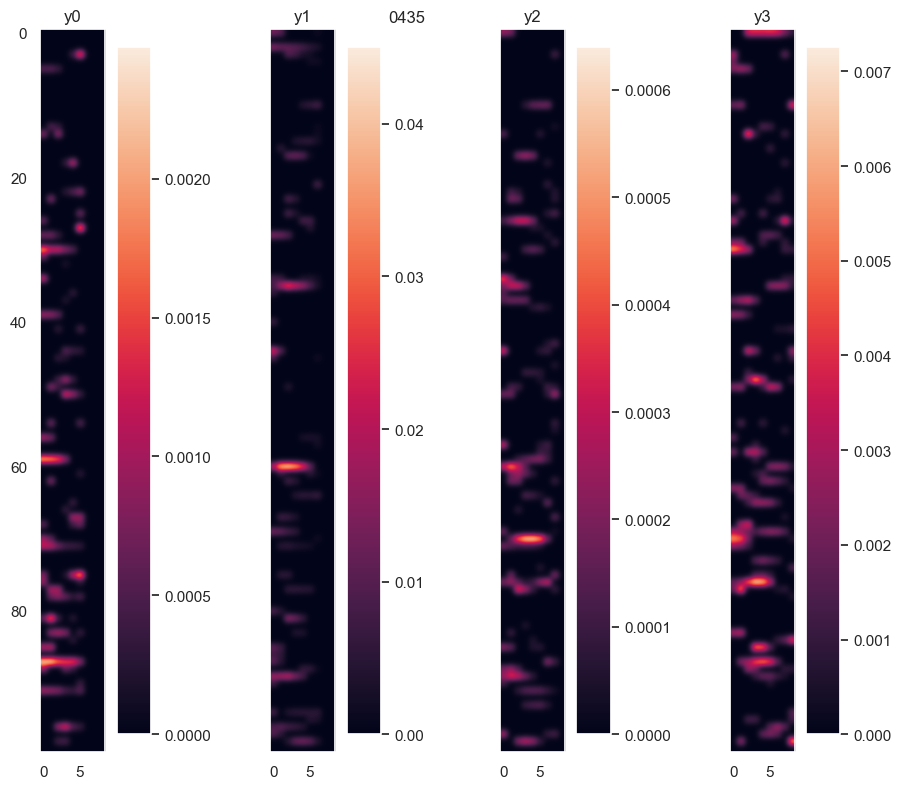

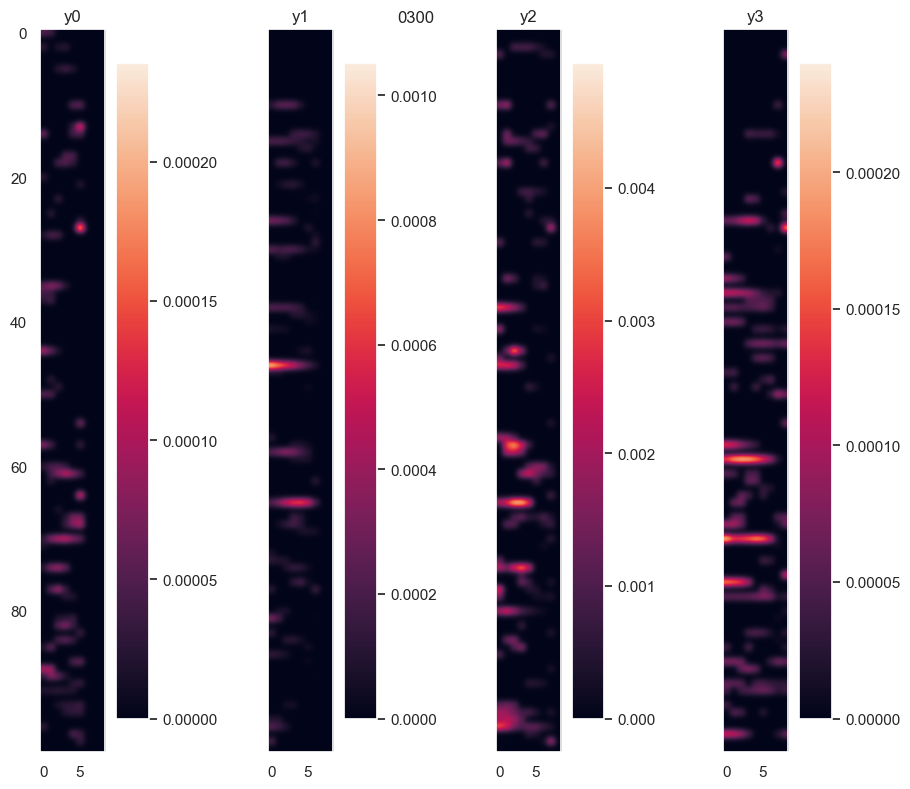

In [394]:
indices = random.sample(list(range(len(name_lst))), k=10)
for idx in indices:
    x0, x1, x2, x3 = list(name_lst[idx])
    grad_tar2hs(int(x0), int(x1), int(x2), int(x3), k=20, title=name_lst[idx])

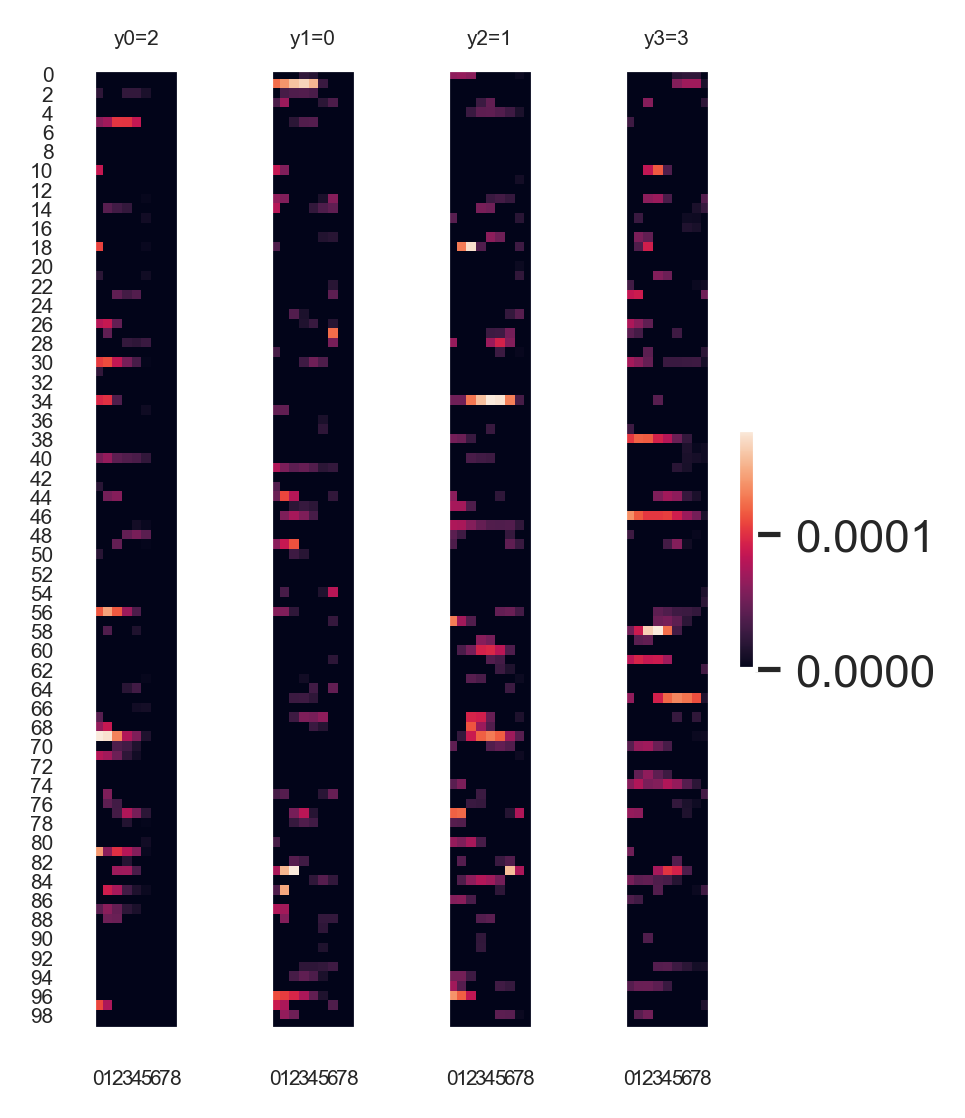

In [384]:
grad_tar2hs(2,0,1,3, k=20)

In [ ]:
grad_tar2hs(2,0,1,3, k=20)

## 表征：空间 v.s. 时间

In [24]:
set2

NameError: name 'set2' is not defined

In [475]:
cs = []
for x0 in range(6):
    for x1 in range(6):
        for x2 in range(6):
            for x3 in range(6):
                inp = build_batch(x0, x1, x2, x3)
                tar = mdl(inp, 4, retain_grad=True)
                c = mdl.get_hs('cs')[:, :, set2]
                cs.append(c)

In [476]:
cs = torch.cat(cs, dim=0)  # (1296, 4 + 1 +4, 11)

In [477]:
cs.shape

torch.Size([1296, 9, 11])

In [478]:
def crutial_cell_img(cs, tidx, cidx):
    img = cs[:, tidx, cidx].view(36, 36)
    plt.imshow(img.detach().cpu())
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

In [479]:
def crutial_cell_logits(cs, tidx, cidx, w):
    img = cs[:, tidx, cidx].view(36, 36) * w
    plt.imshow(img.detach().cpu())
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

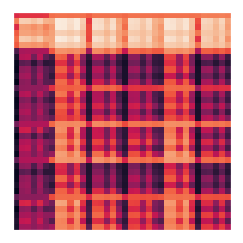

In [456]:
crutial_cell_img(cs, 3, 3)

In [457]:
idices = []
names = []
i = 0
for x0 in range(6):
    for x1 in range(6):
        for x2 in range(6):
            for x3 in range(6):
                names.append(f'{x0}{x1}{x2}{x3}')
                idices.append(i)
                i += 1    
idices = torch.Tensor(idices).int()

In [422]:
idices = idices.view(36, 36)

In [423]:
idices[0]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
       dtype=torch.int32)

In [434]:
[names[idx] for idx in [idices[6, 0]]]    

['1000']

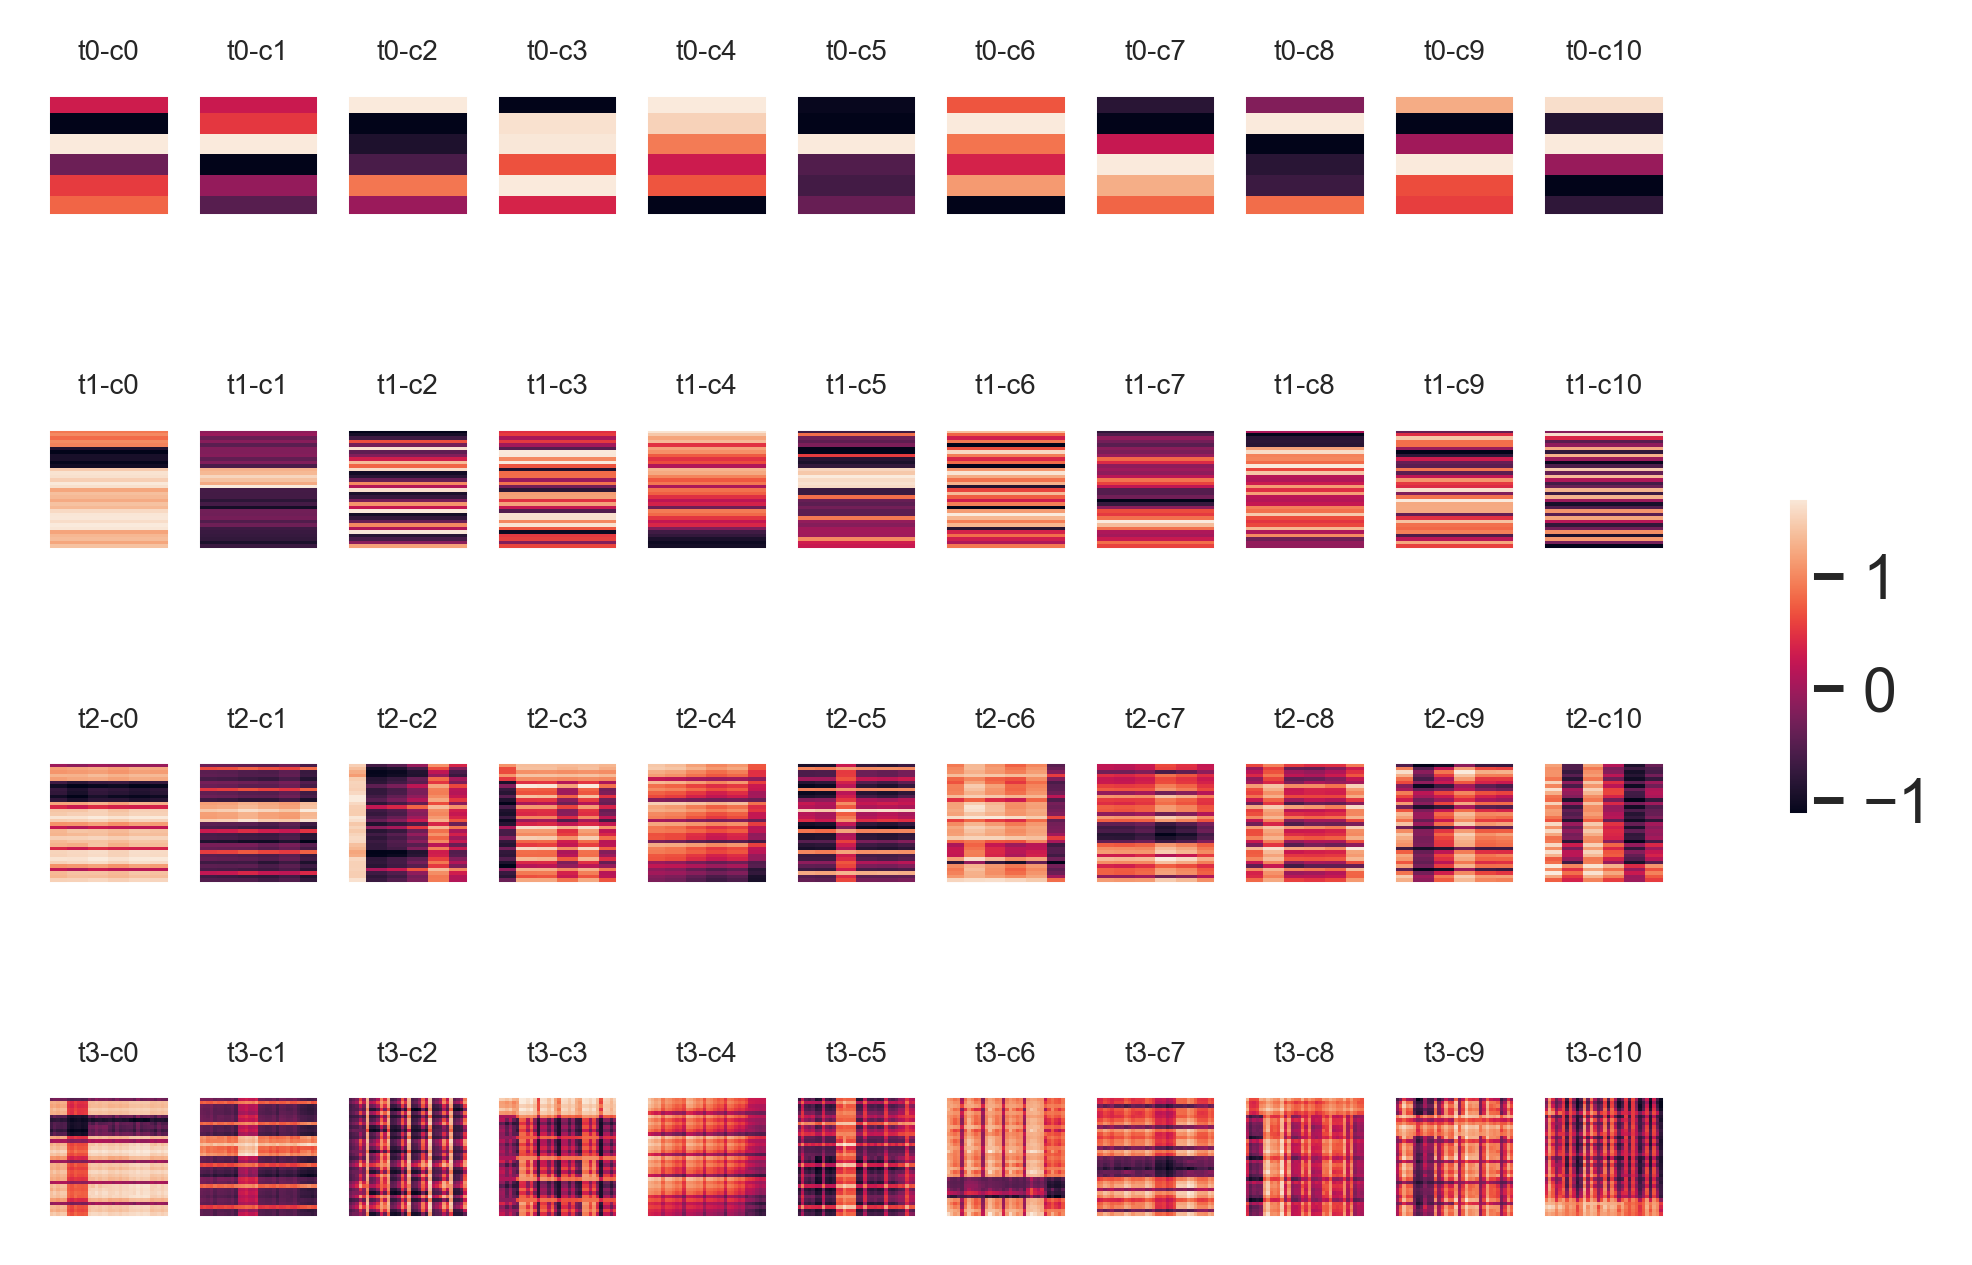

In [480]:
i = 1
fig, _ = plt.subplots()
fig.dpi=400
for tidx in range(4):
    for cidx in range(11): 
        plt.subplot(4, 11, i)
        i += 1
        crutial_cell_img(cs, tidx, cidx)
        plt.title(f't{tidx}-c{cidx}', fontsize=5)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.4, 0.01, 0.2])
plt.colorbar(cax=cax)
plt.show()

In [483]:
cs.shape

torch.Size([1296, 9, 11])

In [493]:
mdl.clf[0].weight.shape

torch.Size([6, 100])

In [528]:
def crutial_cell_out(cs, tidx, cidx, weight):
    # weight: (nclasses=6, ncells=11)
    w_mtrx = torch.zeros(36, 36)
    tidx_delta = tidx - 5 if tidx >= 5 else tidx
    w = weight[tidx_delta, cidx]
    if tidx_delta == 0:
        w_mtrx[:, range(0, 36, 6)] = w
    elif tidx_delta ==1 :
        w_mtrx[:, :6] = w
    elif tidx_delta == 2:
        w_mtrx[range(0, 36, 6), :] = w
    else:
        assert tidx_delta == 3
        w_mtrx[:6, :] = w
        
    img = cs[:, tidx, cidx].view(36, 36) * w_mtrx
    plt.imshow(img.detach().cpu())
    plt.grid(False)
    ticks_x = ['|'] * 6
    ticks_y = ['-'] * 6
    if tidx_delta == 0:
        plt.xticks(range(0, 36, 6), ticks_x, fontsize=2)
        plt.yticks([])
    elif tidx_delta ==1 :
        plt.xticks(range(6), ticks_x, fontsize=2)
        plt.yticks([])
    elif tidx_delta == 2:
        plt.yticks(range(0, 36, 6), ticks_y, fontsize=2)
        plt.xticks([])
    else:
        assert tidx_delta == 3
        plt.yticks(range(6), ticks_y, fontsize=2)
        plt.xticks([])

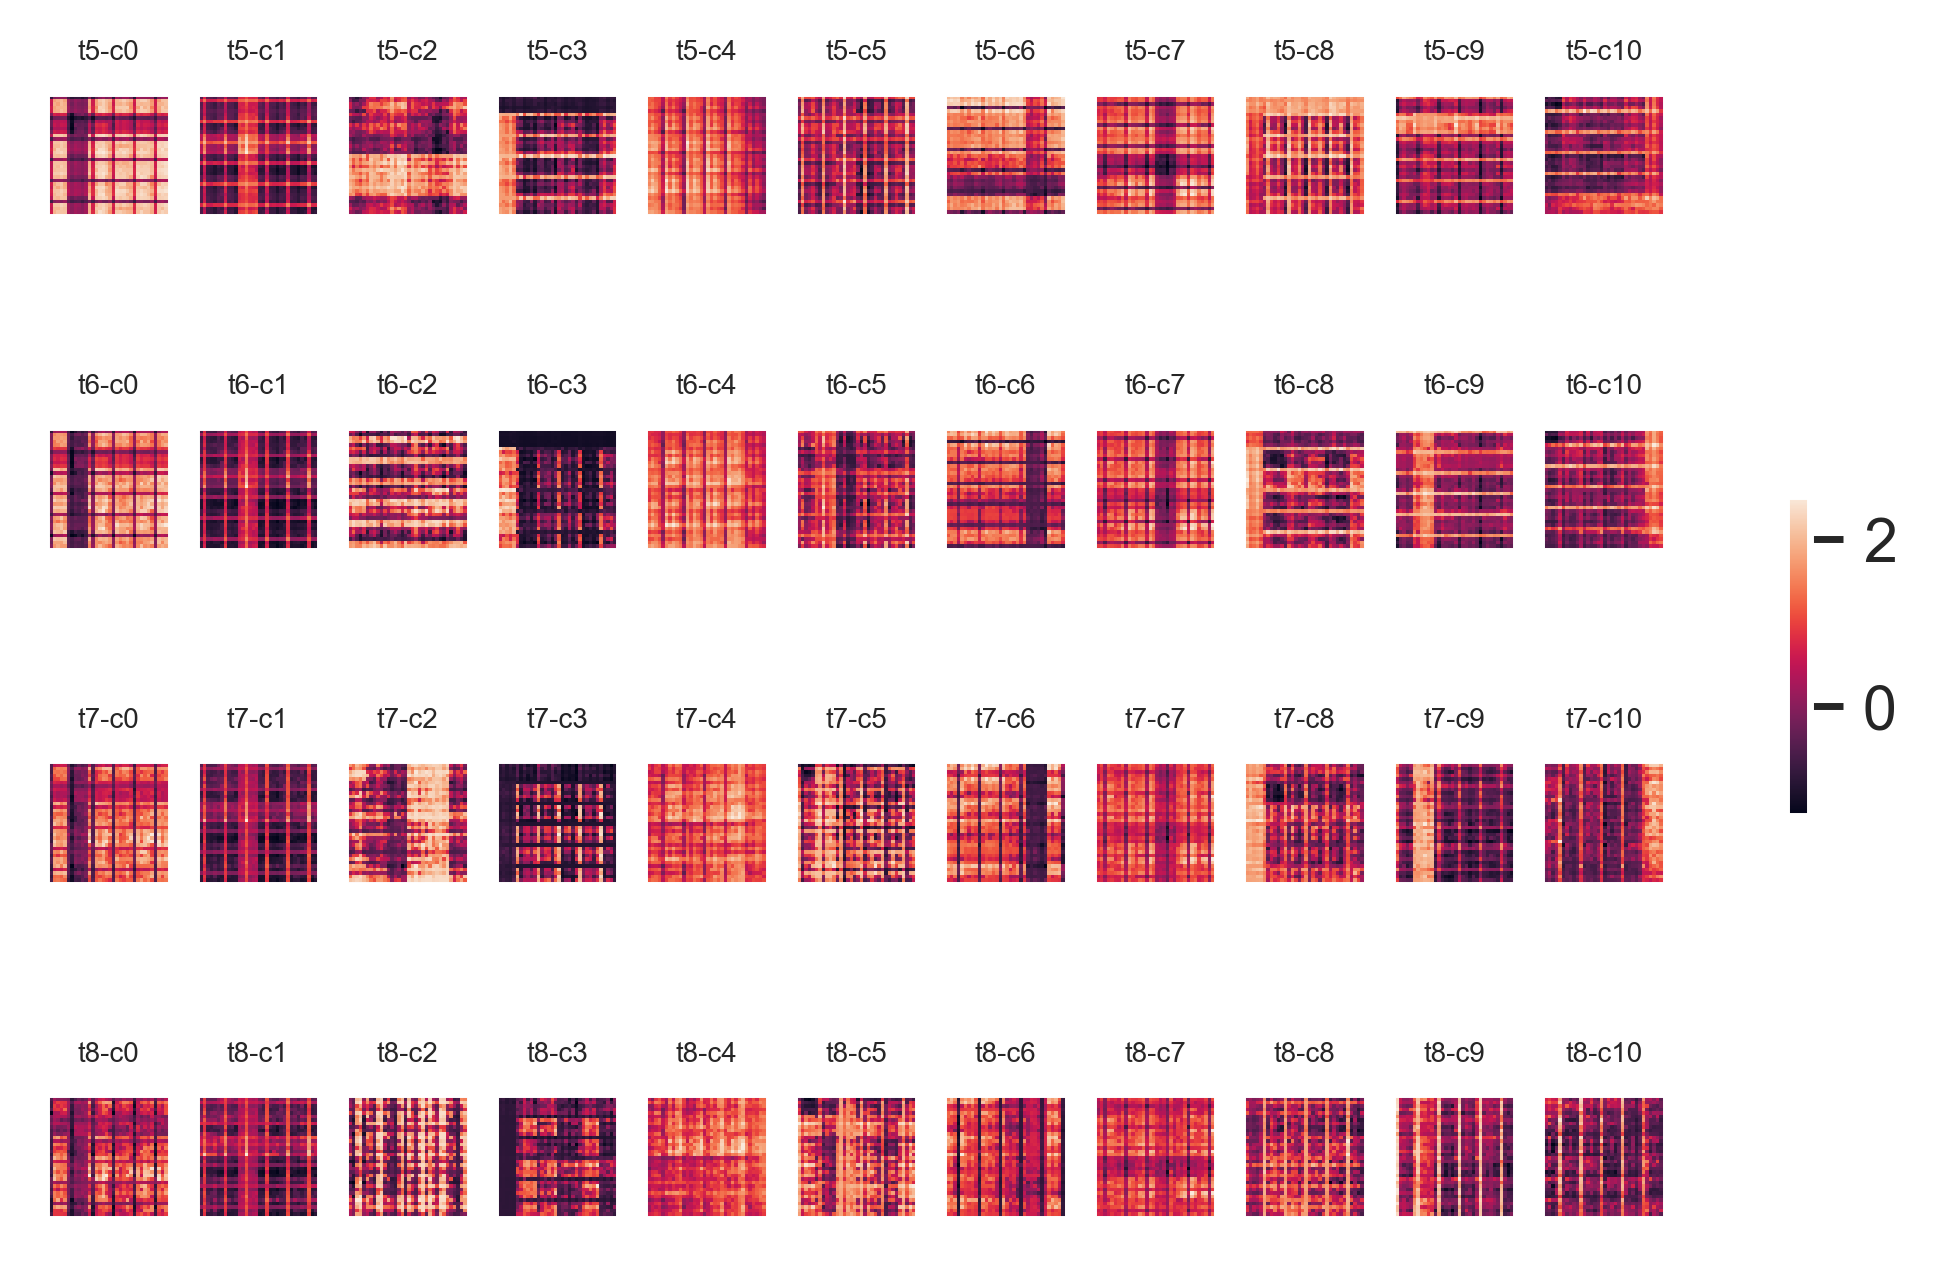

In [496]:
i = 1
fig, _ = plt.subplots()
fig.dpi=400
for tidx in range(5, 9, 1):
    for cidx in range(11): 
        plt.subplot(4, 11, i)
        i += 1
        crutial_cell_img(cs, tidx, cidx)
#         crutial_cell_out(cs, tidx, cidx, mdl.clf[0].weight[:, set2])
        plt.title(f't{tidx}-c{cidx}', fontsize=5)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.4, 0.01, 0.2])
plt.colorbar(cax=cax)
plt.show()

输出时刻

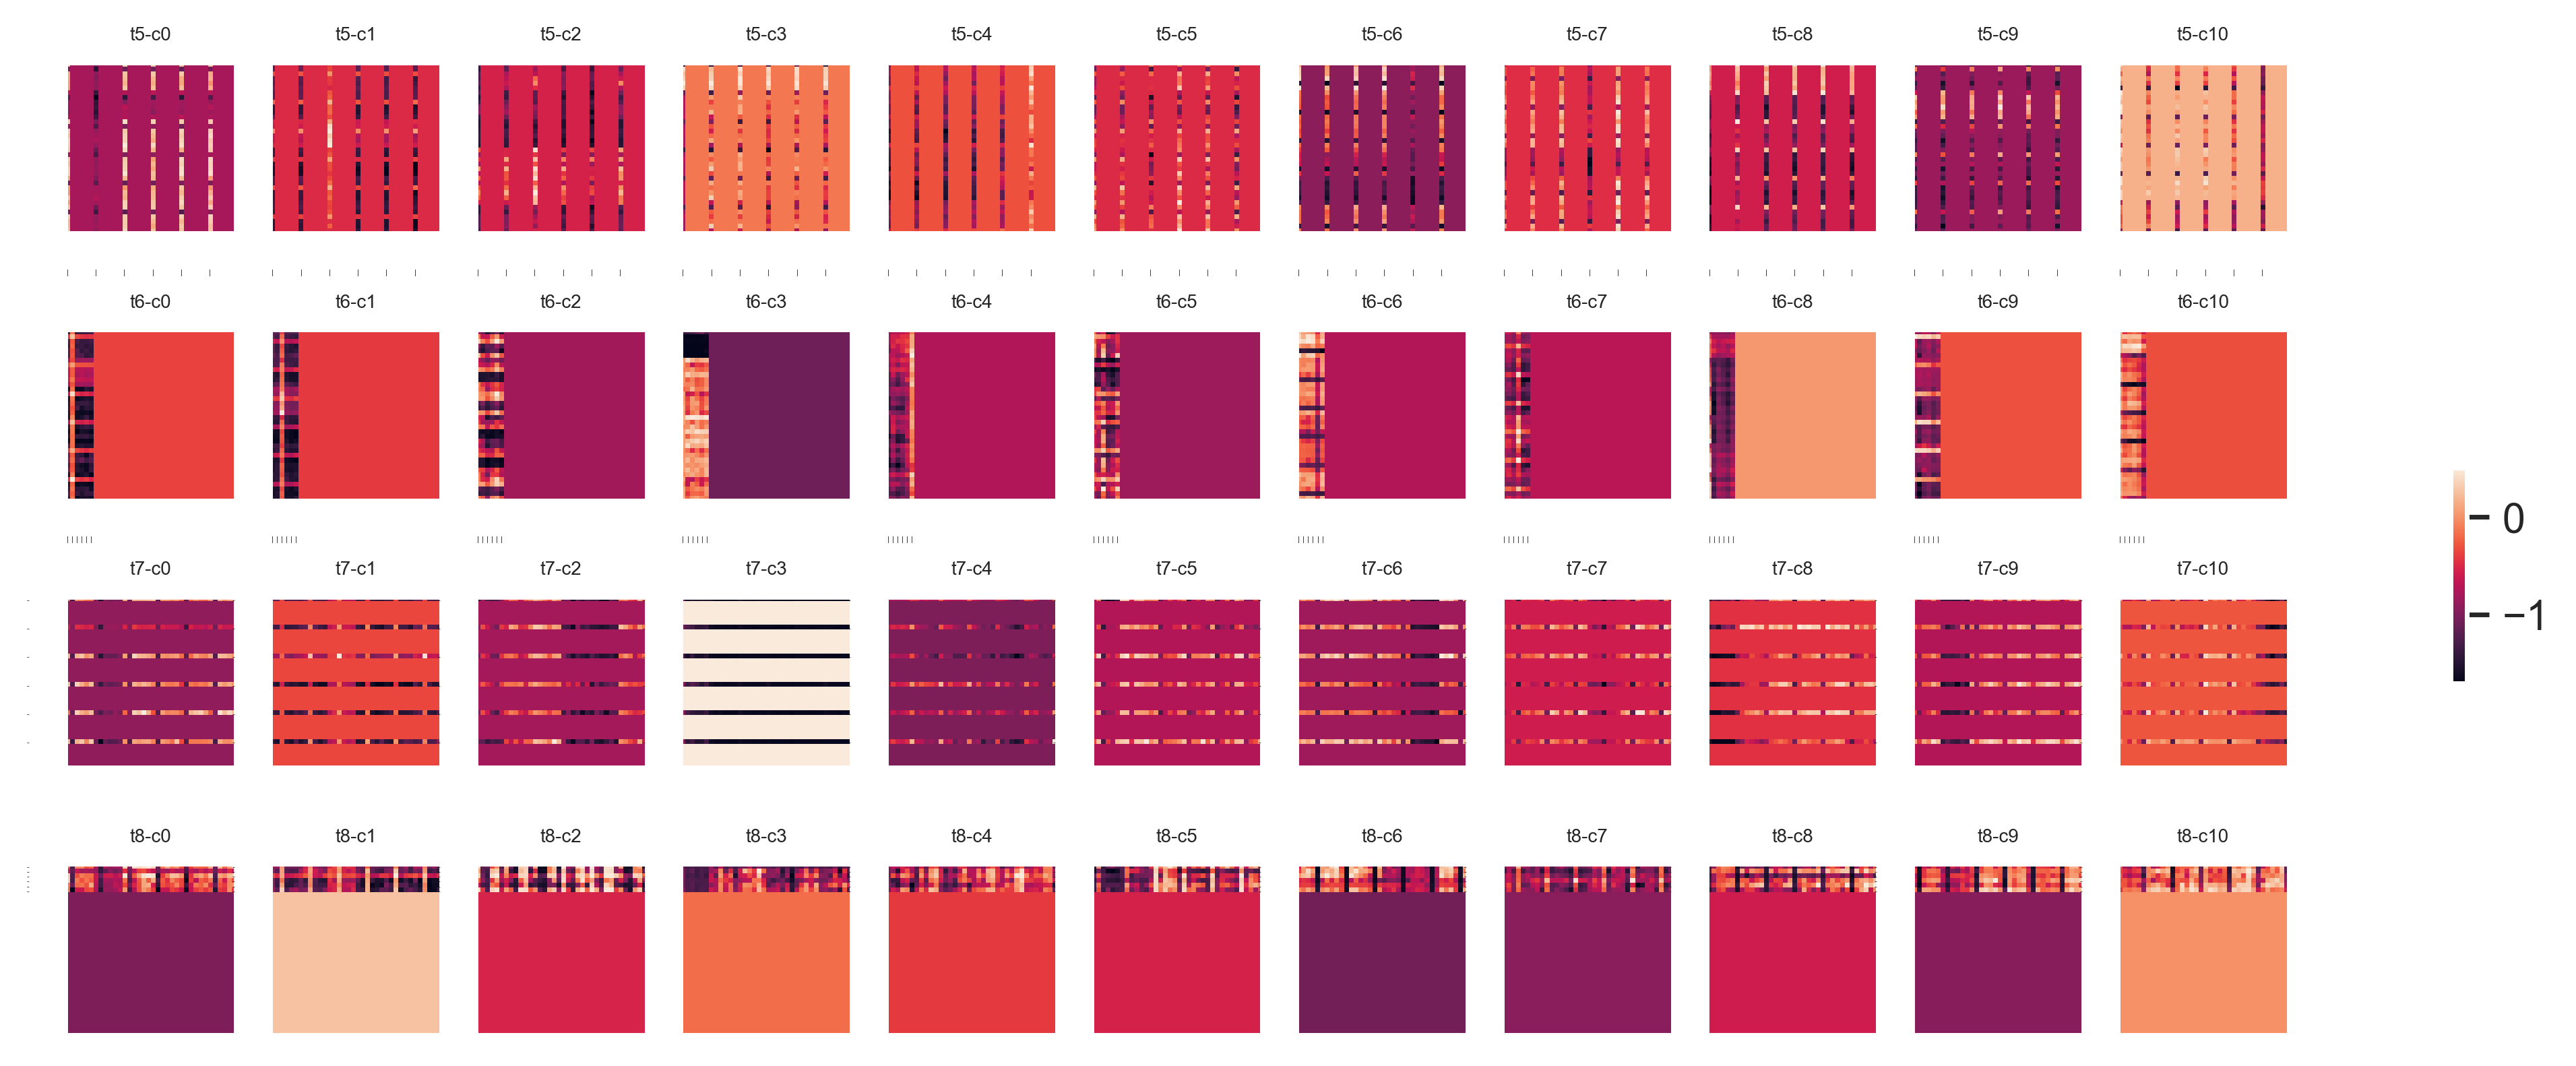

In [529]:
i = 1
fig, _ = plt.subplots()
fig.dpi=400
for tidx in range(5, 9, 1):
    for cidx in range(11): 
        plt.subplot(4, 11, i)
        i += 1
#         crutial_cell_img(cs, tidx, cidx)
        crutial_cell_out(cs, tidx, cidx, mdl.clf[0].weight[:, set2])
        plt.title(f't{tidx}-c{cidx}', fontsize=5)

plt.subplots_adjust(bottom=0.05, right=1.5, top=1)
cax = plt.axes([1.6, 0.4, 0.01, 0.2])
plt.colorbar(cax=cax)
plt.show()

In [459]:
len(set2)

11

In [460]:
mdl.clf[0].weight[:, set2].shape

torch.Size([6, 11])

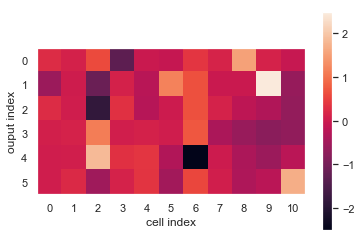

In [530]:
plt.imshow(mdl.clf[0].weight[:, set2].detach().numpy())
plt.xticks(list(range(len(set2))))
plt.xlabel('cell index')
plt.ylabel('ouput index')
plt.grid()
plt.colorbar()

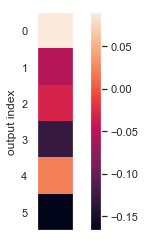

In [531]:
plt.imshow(mdl.clf[0].bias.view(-1, 1).detach().numpy())
plt.xticks([])
plt.ylabel('output index')
plt.grid()
plt.colorbar()

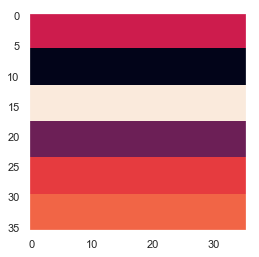

In [401]:
crutial_cell_img(cs, 0, 1)

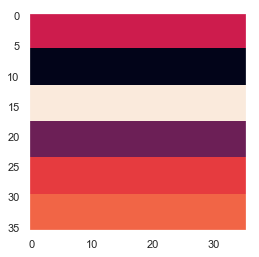

In [406]:
crutial_cell_img(cs, 4, 2)

In [ ]:
def plot_hs_random(name='cs', k=5):
    fig, _= plt.subplots()
    fig.dpi = 300
    indices = random.sample(list(range(len(name_lst))), k=k)
    for i, idx in enumerate(indices):
        plt.subplot(1, k + 1, i + 1)
#         ax.set_figure(plt.figure(dpi=100))
#         fig.dpi = 300
        x0, x1, x2, x3 = map(int, list(name_lst[idx]))
        plot_hs(x0, x1, x2, x3, name)
        plt.title(f'{name}-{x0}{x1}{x2}{x3}', fontsize=5)
        plt.xticks(list(range(4 + 1 + 4)), fontsize=5)
        plt.yticks(list(range(0, 100, 2)), fontsize=5)
        if i != 0:
            plt.yticks([])

    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.7, 0.4, 0.01, 0.2])
    plt.colorbar(cax=cax)
    plt.show()

## 解藕空间v.s.时间

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import random

In [12]:
hlst = []
name_lst = []
for x0 in range(6):
    for x1 in range(6):
        for x2 in range(6):
            for x3 in range(6):
                inp = build_batch(x0, x1, x2, x3)
                tar = mdl(inp, 4, retain_grad=True)
#                 hs = mdl.get_hs('cs')  # hs: (bsz, ilen+tlen, hdim)
                hs = mdl.get_hs('hs')  # hs: (bsz, ilen+tlen, hdim)
                h = hs[0, 4, set3].detach().numpy()
                hlst.append(h)
                name_lst.append(f'{x0}{x1}{x2}{x3}')
#                 name_lst.append(''.join(sorted(f'{x0}{x1}{x2}{x3}')))
#                 name_lst.append(str(len(set(f'{x0}{x1}{x2}{x3}'))))

NameError: name 'set3' is not defined

In [315]:
remain = 1
total = len(name_lst)
sampled_indices = random.sample(list(range(total)), k=int(remain * total))

In [316]:
def index_from(lst, indices):
    return [lst[idx] for idx in indices]

In [317]:
hs_sampled = np.array(index_from(hlst, sampled_indices))
names_sampled = index_from(name_lst, sampled_indices)

In [325]:
# rep_emb = TSNE(n_components=2).fit_transform(rep)
pca = PCA(n_components=2)
embs = pca.fit_transform(hs_sampled)

In [326]:
pca.singular_values_

array([33.20726 , 30.461142], dtype=float32)

In [327]:
pca.singular_values_[:2].sum() / pca.singular_values_.sum()

1.0

In [328]:
embs.shape

(1296, 2)

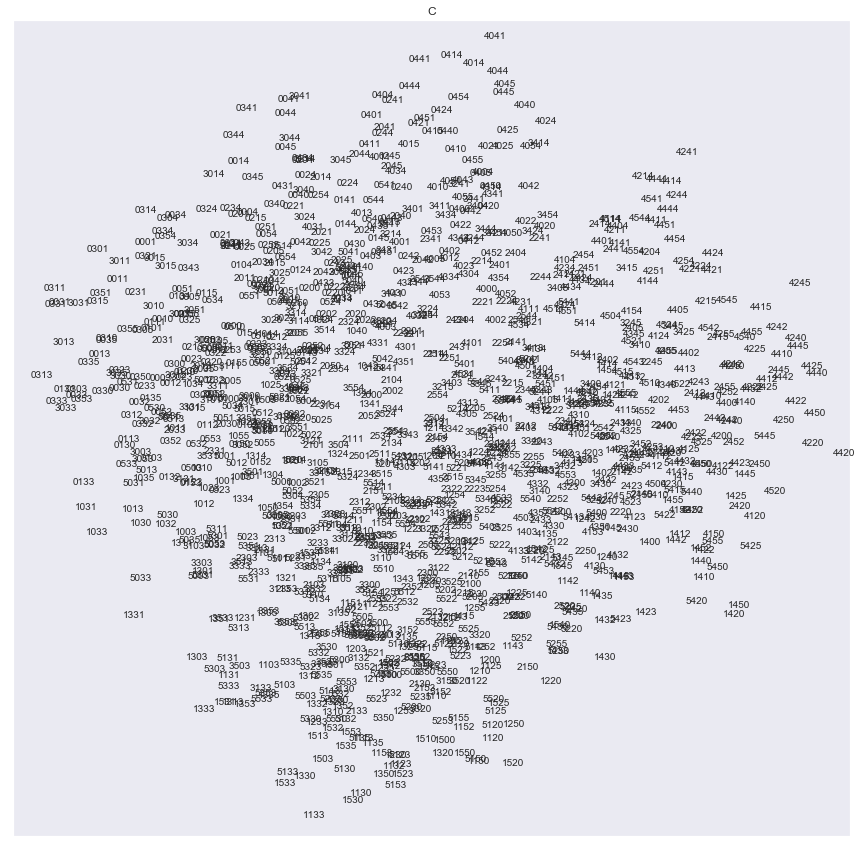

In [329]:
emb_min, emb_max = embs.min(0) - 0.1, embs.max(0) + 0.1
emb_norm = (embs - emb_min) / (emb_max - emb_min)
plt.figure(figsize=(15, 15))
for emb, name in zip(emb_norm, names_sampled):
    plt.text(emb[0], emb[1], name, fontsize=10)
#     plt.text(emb[0], emb[1], name, fontsize=10)
plt.xticks([])
plt.yticks([])
plt.title('C')
plt.show()

时间：相同位置（时刻）上重合的比例

空间：跨位置（空间）意义下重合比例

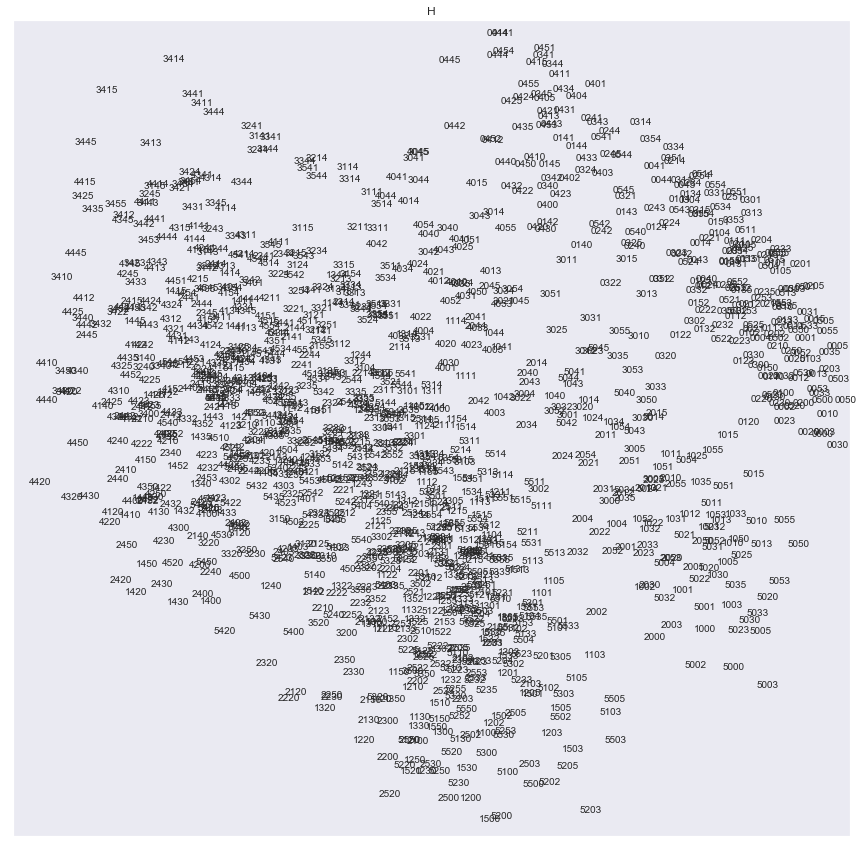

In [360]:
emb_min, emb_max = embs.min(0) - 0.1, embs.max(0) + 0.1
emb_norm = (embs - emb_min) / (emb_max - emb_min)
plt.figure(figsize=(15, 15))
for emb, name in zip(emb_norm, names_sampled):
    plt.text(emb[0], emb[1], name, fontsize=10)
#     plt.text(emb[0], emb[1], name, fontsize=10)
plt.xticks([])
plt.yticks([])
plt.title('H')
plt.show()

## saturated%

In [42]:
def saturated_ratio(gate_name, ax):
    gate_l_lst = []
    gate_r_lst= []
    for x0 in range(6):
        for x1 in range(6):
            for x2 in range(6):
                for x3 in range(6):
                    inp = build_batch(x0, x1, x2, x3)
                    tar = mdl(inp, 4)
#                     print(f'{x0}{x1}{x2}{x3}')
                    gate = mdl.get_hs(gate_name)
                    gate = mdl.get_hs(gate_name)  # (bsz=1, ilen + tlen, hdim)
                    gate_l = gate.le(0.1)
                    gate_r = gate.ge(0.9)
                    gate_l_lst.append(gate_l)
                    gate_r_lst.append(gate_r)
    gate_l_lst = torch.cat(gate_l_lst, dim=0)  # (nseqs, ilen + tlen, hdim)
    gate_r_lst = torch.cat(gate_r_lst, dim=0)  # (nseqs, ilen + tlen, hdim)
    ratio_l = gate_l_lst.sum(dim=-1).float() / gate_l_lst.shape[-1]  # (nseqs, ilen + tlen)
    ratio_r = gate_r_lst.sum(dim=-1).float() / gate_r_lst.shape[-1]
    ratio_l = ratio_l.detach().numpy()
    ratio_r = ratio_r.detach().numpy()
    res = ax.errorbar(x=list(range(ratio_l.shape[1])), 
                      y=np.mean(ratio_l, axis=0), 
                      yerr=np.std(ratio_l, axis=0), 
                      label=f'{gate_name}-left',
                      marker='<')
    ax.errorbar(x=list(range(ratio_r.shape[1])), 
                y=np.mean(ratio_r, axis=0), 
                yerr=np.std(ratio_r, axis=0), 
                color=res[0].get_color(),
                label=f'{gate_name}-right',
                marker='>')

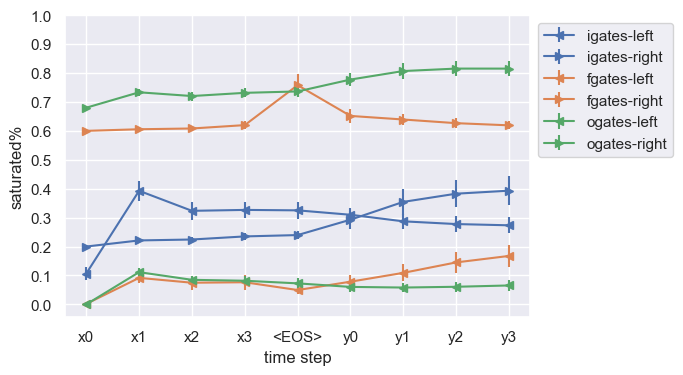

In [43]:
mdl = torch.load('lstm-clf-repeat-mky-whole.mdl')
fig, ax = plt.subplots()
fig.dpi = 100
saturated_ratio('igates', ax)
saturated_ratio('fgates', ax)
saturated_ratio('ogates', ax)
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(list(range(4 + 1 + 4)), ['x0', 'x1', 'x2', 'x3', '<EOS>', 'y0', 'y1', 'y2', 'y3'])
plt.xlabel('time step')
plt.ylabel('saturated%')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

## mean gate value

In [49]:
def mean_gate(gate_name, ax):
    gate_lst = []
    for x0 in range(6):
        for x1 in range(6):
            for x2 in range(6):
                for x3 in range(6):
                    inp = build_batch(x0, x1, x2, x3)
                    tar = mdl(inp, 4)
                    gate = mdl.get_hs(gate_name)
                    gate_lst.append(gate)
                    
    gate_lst = torch.cat(gate_lst, dim=0)  # (nseqs, ilen + tlen, hdim)
    mean_along_hdim = gate_lst.mean(dim=-1)  # (nseqs, ilen + tlen)
    mean_val = mean_along_hdim.detach().numpy()
    ax.errorbar(x=list(range(mean_val.shape[1])), 
                      y=np.mean(mean_val, axis=0), 
                      yerr=np.std(mean_val, axis=0), 
                      label=f'{gate_name}')

/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


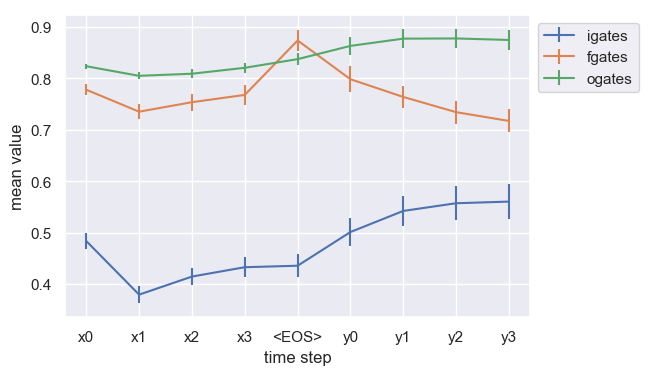

In [50]:
mdl = torch.load('lstm-clf-repeat-mky-whole.mdl')
fig, ax = plt.subplots()
fig.dpi = 100
mean_gate('igates', ax)
mean_gate('fgates', ax)
mean_gate('ogates', ax)
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(list(range(4 + 1 + 4)), ['x0', 'x1', 'x2', 'x3', '<EOS>', 'y0', 'y1', 'y2', 'y3'])
plt.xlabel('time step')
plt.ylabel('mean value')
plt.show()

## 抽取自动机

In [46]:
from sklearn.cluster import KMeans
from collections import defaultdict
from graphviz import Digraph
def extract_fsm(hs_name='hs', pos_feature=False, k=20):        
        hlst = []
        ilst = []
        alst = []
        blst = []
        pos_pad = torch.zeros(6 * 6 * 6 * 6)
        i = 0
        mdl = torch.load('lstm-clf-repeat-mky-whole.mdl')
        for x0 in range(6):
            for x1 in range(6):
                for x2 in range(6):
                    for x3 in range(6):
                        inp = build_batch(x0, x1, x2, x3)
                        tar = mdl(inp, 4, retain_grad=True)
                        hs = mdl.get_hs(hs_name)  # hs: (bsz, ilen+tlen, hdim)
                        seq_len = hs.shape[1]
                        inp = [str(x0), str(x1), str(x2), str(x3), 'e', 
                               f'0-{x0}', f'0-{x1}', f'0-{x2}', f'0-{x3}']
#                         inp = [str(x0), str(x1), str(x2), str(x3), 'e', 
#                                f'0', f'0', f'0', f'0']
                        for t in range(seq_len):
                            pos_ft = pos_pad.clone()
                            pos_ft[i] = t
                            ft = torch.cat([hs[0, t], pos_ft])
                            hlst.append(ft.detach().numpy())
                            ilst.append(inp[t])
                            alst.append(int(t==seq_len-1))
                            blst.append(int(t==0))
                        i += 1
        hs = np.array(hlst)
        kmeans = KMeans(n_clusters=k, random_state=0)
        if pos_feature:
            distance = kmeans.fit_transform(hs)
        else:
            distance = kmeans.fit_transform(hs[:, :100])
        
        labels = kmeans.labels_
        Q = set(labels)
        Q.add('b')
        V = set(ilst)
        Nsij = defaultdict(int)
        
        for i, (lbl, inp) in enumerate(zip(labels, ilst)):
            if blst[i] == 1:
                lbl_prev = 'b'
            else:
                lbl_prev = labels[i-1]
            Nsij[(inp, lbl_prev, lbl)] += 1
        T = defaultdict(int)
        for i in Q:
            for s in V:
                max_times = 0
                k = 0
                for j in Q:
                    ntimes = Nsij[(s, i, j)]
                    if ntimes > max_times:
                        k = j
                        max_times = ntimes
                T[(i, s)] = k
        F = set()
        for lbl, acc in zip(labels, alst):
            if acc == 1:
                F.add(lbl)
        return V, Q, T, F

In [126]:
def visualize_fsm(V, Q, T, F, filiter_illegal=False):
    f = Digraph('finite_state_machine', filename='fsm.gv')
    f.attr(rankdir='LR', size='10,10')

    f.attr('node', shape='doublecircle')
    for fstate in F:
        f.node(f'q{fstate}')
    
    f.attr('node', shape='circle')
    for (i, s), j in T.items():
        if filiter_illegal:
            if j == 'b':
                continue
            if i == 'b' and s == 'e':
                continue
            if  i == 'b' and '-' in s:
                continue
            if i in F and j in F and '-' not in s:
                continue
            if '-' in s and j not in F:
                continue
        state_i = 'start' if i == 'b' else f'q{i}'
        state_j = 'start' if j == 'b' else f'q{j}'
        f.edge(state_i, state_j, label=f'{s}')
    f.view()

In [75]:
mdl = torch.load('lstm-clf-repeat-mky-whole.mdl')
inp = build_batch(0, 1, 2, 3)
tar = mdl(inp, 4, retain_grad=True)
print(tar.shape)

torch.Size([1, 4, 6])


In [79]:
tar[0].max(-1)[1]

tensor([0, 1, 2, 3])

In [170]:
def accept_ratio(fsm):
    def halt(fsm, seq):
        V, Q, T, F = fsm
        assert 'b' in Q
        q = 'b'
        for inp in seq:
            if (q, inp) in T:
                q = T[(q, inp)]
            else:
                return False
        return q in F
    
    nhalt = 0
    ntotal = 0
    V, Q, T, F = fsm
    for x0 in range(6):
        for x1 in range(6):
            for x2 in range(6):
                for x3 in range(6):
                    inp = build_batch(x0, x1, x2, x3)
                    tar = mdl(inp, 4, retain_grad=True)
                    y0, y1, y2, y3 = tar[0].max(-1)[1].detach().numpy().tolist()
                    seq = list(map(str, [x0, x1, x2, x3, 'e', f'0-{y0}', f'0-{y1}', f'0-{y2}', f'0-{y3}']))
#                     print(seq)
                    is_halt = halt(fsm, seq)
                    nhalt += int(is_halt)
                    ntotal += 1
    return nhalt / ntotal

In [154]:
def filter_illegal(V, Q, T, F):
    T_res = defaultdict(int)
    for (i, s), j in T.items():
        if j == 'b':
            continue
        if i == 'b' and s == 'e':
            continue
        if  i == 'b' and '-' in s:
            continue
        if i in F and j in F and '-' not in s:
            continue
        if i in F and j not in F:
            continue
        if '-' in s and j not in F:
            continue
        if '-' not in s and j in F:
            continue
        T_res[(i, s)] = j
    return V, Q, T_res, F

In [177]:
for k in range(1, 10):
    fsm_hs = extract_fsm(hs_name='hs', k=k, pos_feature=True)
    res = filter_illegal(*fsm_hs)
    ratio =accept_ratio(res)
    print(k, ratio)

/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


1 0.0


/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


2 0.0


/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


3 0.0


/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


4 1.0


/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


5 1.0


/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


6 1.0


/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


7 0.8341049382716049


/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


8 0.8341049382716049


/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


9 1.0


In [180]:
fsm_hs = extract_fsm(hs_name='hs', k=9, pos_feature=True)
res = filter_illegal(*fsm_hs)

/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [181]:
visualize_fsm(*res)

In [176]:
for k in range(1, 5):
    fsm_hs = extract_fsm(hs_name='cs', k=k, pos_feature=True)
    res = filter_illegal(*fsm_hs)
    ratio =accept_ratio(res)
    print(k, ratio)

/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


1 0.0


/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


2 1.0


/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


3 0.16589506172839505


/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


4 0.3325617283950617


In [171]:
accept_ratio(res)

0.0

In [166]:
res

({'0', '0-0', '0-1', '0-2', '0-3', '0-4', '0-5', '1', '2', '3', '4', '5', 'e'},
 {0, 1, 'b'},
 defaultdict(int,
             {(0, '0-3'): 1,
              (0, '0-5'): 1,
              (0, '0-2'): 1,
              (0, '0-4'): 1,
              (0, '0-0'): 0,
              (0, '0-1'): 1,
              (1, '0-3'): 1,
              (1, '0-5'): 1,
              (1, '0-2'): 1,
              (1, '0-4'): 1,
              (1, '0-0'): 1,
              (1, '0-1'): 1}),
 {0, 1})

In [167]:
visualize_fsm(*res)

In [ ]:
def halt(fsm, seq):
        V, Q, T, F = fsm
        assert 'b' in Q
        q = 'b'
        for inp in seq:
            q = T[(q, inp)]
        return q in F

In [147]:
visualize_fsm(*fsm_hs_filtered)

In [144]:
visualize_fsm(*fsm_hs_filtered)

In [138]:
visualize_fsm(*fsm_hs, filiter_illegal=True)

In [135]:
fsm_cs = extract_fsm(hs_name='cs', k=2, pos_feature=True)

/Users/marc/miniconda3/envs/ltree/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'lstm_clf.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [136]:
visualize_fsm(*fsm_cs, filiter_illegal=True)

# 11个神经元的门控

In [61]:
set2 = [1, 5, 14, 18, 37, 49, 50, 60, 68, 83, 88]

In [49]:
def saturated_ratio(gate_name, ax, cidx):
    gate_l_lst = []
    gate_r_lst= []
    for x0 in range(6):
        for x1 in range(6):
            for x2 in range(6):
                for x3 in range(6):
                    inp = build_batch(x0, x1, x2, x3)
                    tar = mdl(inp, 4)
#                     print(f'{x0}{x1}{x2}{x3}')
#                     gate = mdl.get_hs(gate_name)
                    gate = mdl.get_hs(gate_name)[:,:,[cidx] if type(cidx) != list else cidx]  # (bsz=1, ilen + tlen, hdim)
                    gate_l = gate.le(0.1)
                    gate_r = gate.ge(0.9)
                    gate_l_lst.append(gate_l)
                    gate_r_lst.append(gate_r)
    gate_l_lst = torch.cat(gate_l_lst, dim=0)  # (nseqs, ilen + tlen, hdim)
    gate_r_lst = torch.cat(gate_r_lst, dim=0)  # (nseqs, ilen + tlen, hdim)
    ratio_l = gate_l_lst.sum(dim=-1).float() / gate_l_lst.shape[-1]  # (nseqs, ilen + tlen)
    ratio_r = gate_r_lst.sum(dim=-1).float() / gate_r_lst.shape[-1]
    ratio_l = ratio_l.detach().numpy()
    ratio_r = ratio_r.detach().numpy()
    res = ax.errorbar(x=list(range(ratio_l.shape[1])), 
                      y=np.mean(ratio_l, axis=0), 
                      yerr=np.std(ratio_l, axis=0), 
                      label=f'{gate_name}-left',
                      marker='<', alpha=0.5)
    ax.errorbar(x=list(range(ratio_r.shape[1])), 
                y=np.mean(ratio_r, axis=0), 
                yerr=np.std(ratio_r, axis=0), 
                color=res[0].get_color(),
                label=f'{gate_name}-right',
                marker='>', alpha=0.5)

In [55]:
def mean_gate(gate_name, ax, cidx):
    gate_lst = []
    for x0 in range(6):
        for x1 in range(6):
            for x2 in range(6):
                for x3 in range(6):
                    inp = build_batch(x0, x1, x2, x3)
                    tar = mdl(inp, 4)
                    gate = mdl.get_hs(gate_name)[:,:,[cidx] if type(cidx) != list else cidx]  # (bsz=1, ilen + tlen, hdim)
                    gate_lst.append(gate)
                    
    gate_lst = torch.cat(gate_lst, dim=0)  # (nseqs, ilen + tlen, hdim)
    mean_along_hdim = gate_lst.mean(dim=-1)  # (nseqs, ilen + tlen)
    mean_val = mean_along_hdim.detach().numpy()
    ax.errorbar(x=list(range(mean_val.shape[1])), 
                      y=np.mean(mean_val, axis=0), 
                      yerr=np.std(mean_val, axis=0), 
                      label=f'{gate_name}')

In [53]:
def aio(cidx):
    mdl = torch.load('lstm-clf-repeat-mky-whole.mdl')
    fig, ax = plt.subplots()
    fig.dpi = 100
    saturated_ratio('igates', ax, cidx)
    saturated_ratio('fgates', ax, cidx)
#     saturated_ratio('ogates', ax, cidx)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(list(range(4 + 1 + 4)), ['x0', 'x1', 'x2', 'x3', '<EOS>', 'y0', 'y1', 'y2', 'y3'])
    plt.xlabel('time step')
    plt.ylabel('saturated%')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title(f'cell-{cidx}')
    plt.show()

In [62]:
def aio_gate(cidx):
    mdl = torch.load('lstm-clf-repeat-mky-whole.mdl')
    fig, ax = plt.subplots()
    fig.dpi = 100
    mean_gate('igates', ax, cidx)
    mean_gate('fgates', ax, cidx)
    mean_gate('ogates', ax, cidx)
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(list(range(4 + 1 + 4)), ['x0', 'x1', 'x2', 'x3', '<EOS>', 'y0', 'y1', 'y2', 'y3'])
    plt.xlabel('time step')
    plt.ylabel('saturated%')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title(f'cell-{cidx}')
    plt.show()

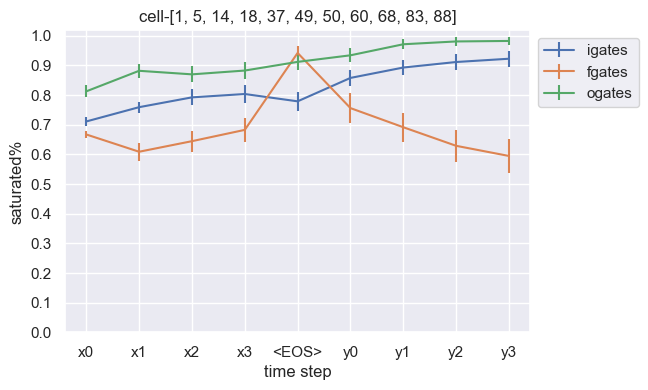

In [63]:
aio_gate(set2)

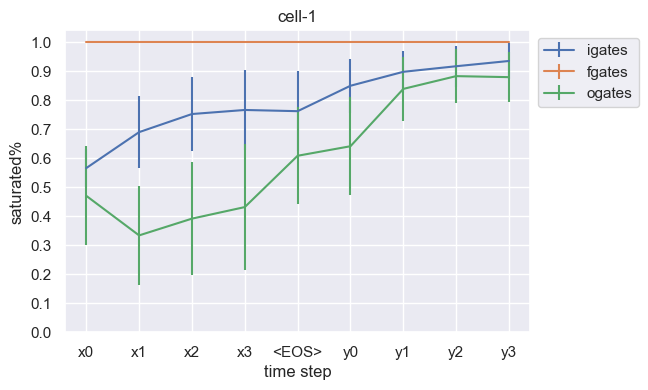

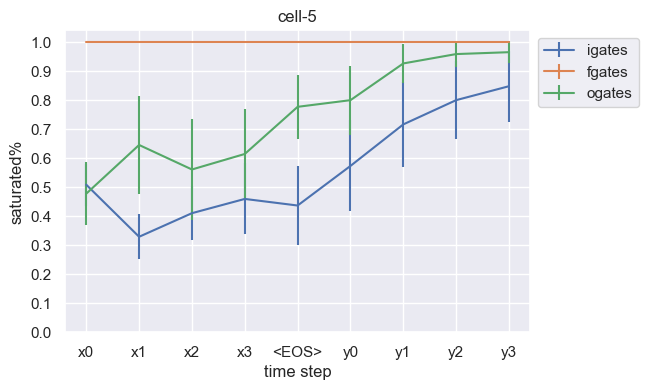

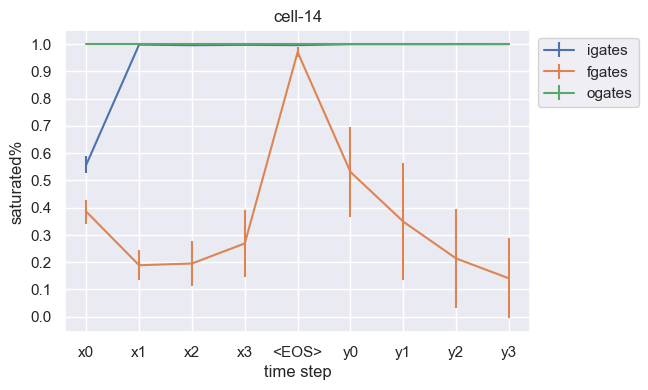

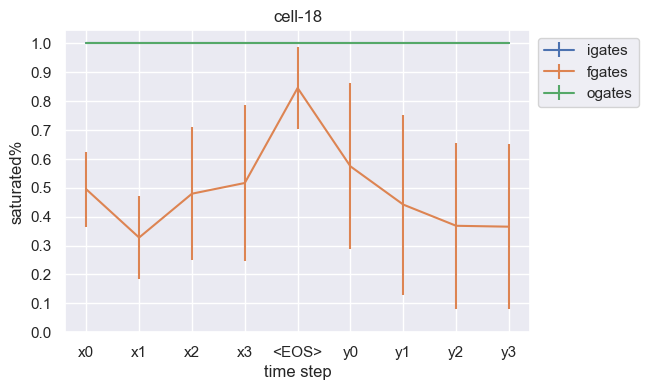

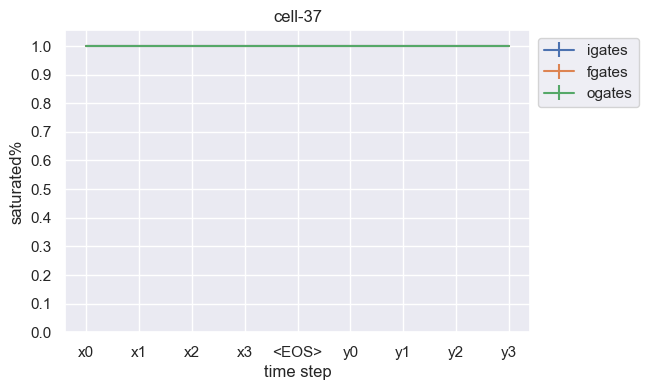

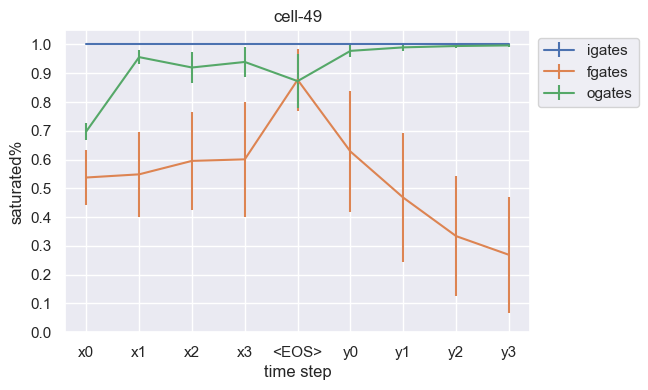

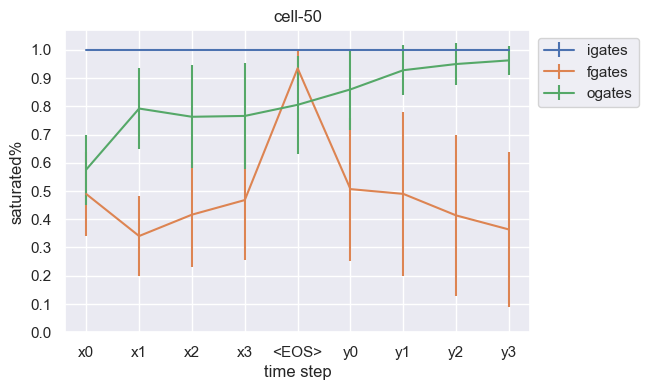

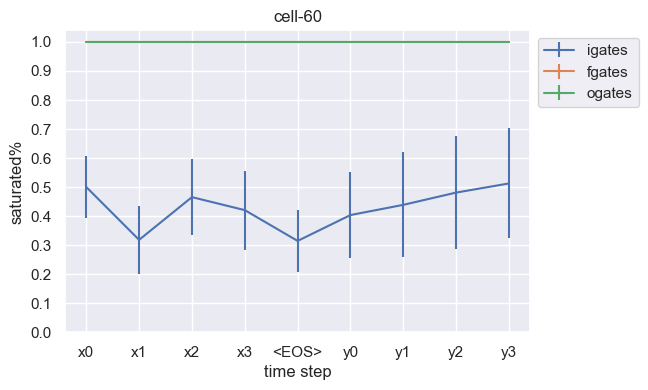

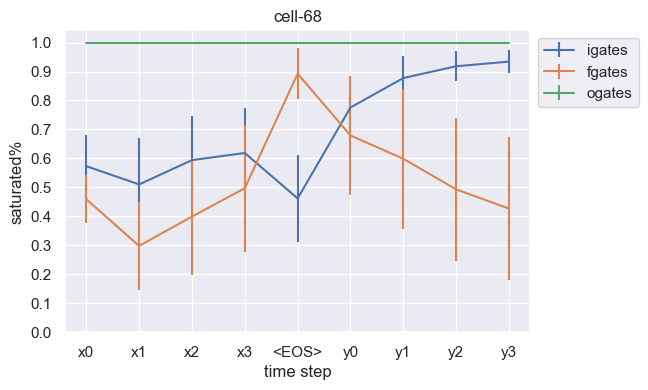

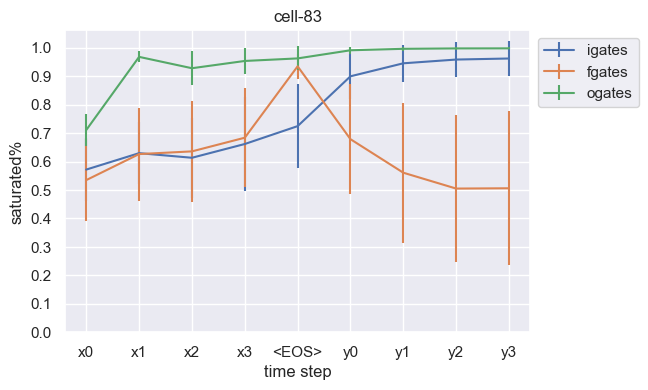

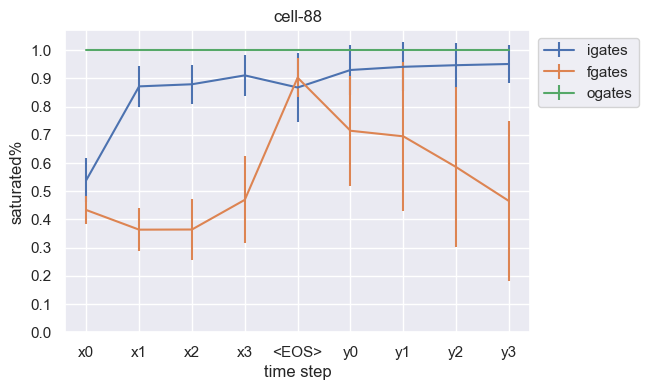

In [64]:
for cidx in set2:
    aio_gate(cidx)

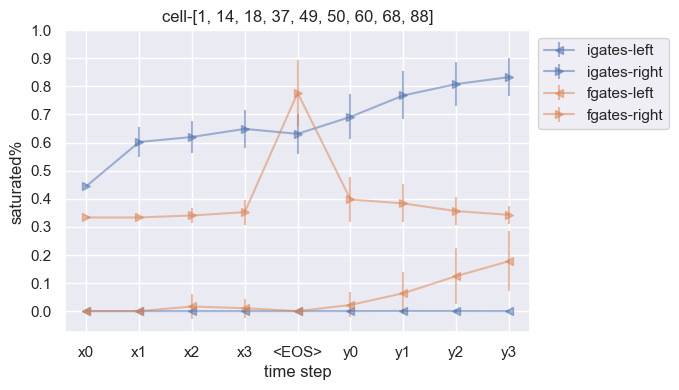

In [54]:
aio(set2)

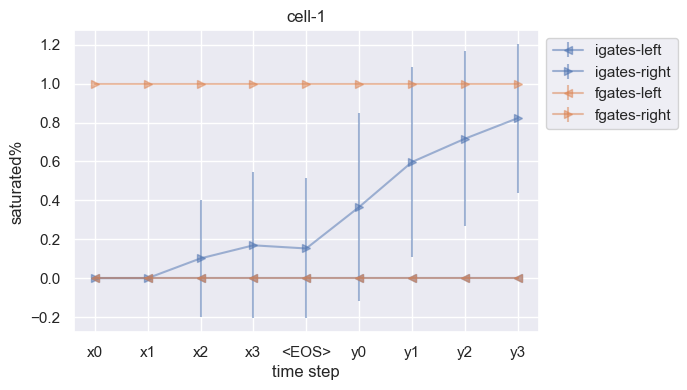

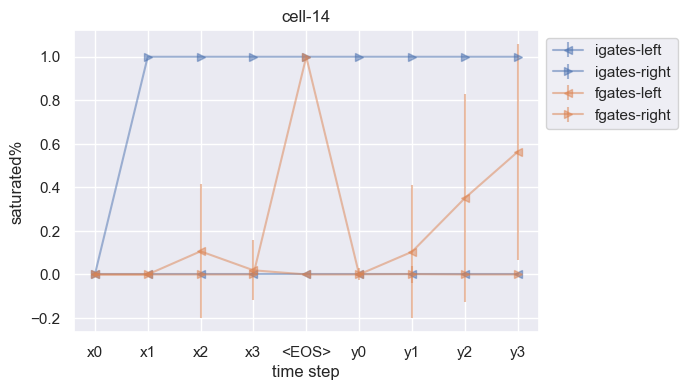

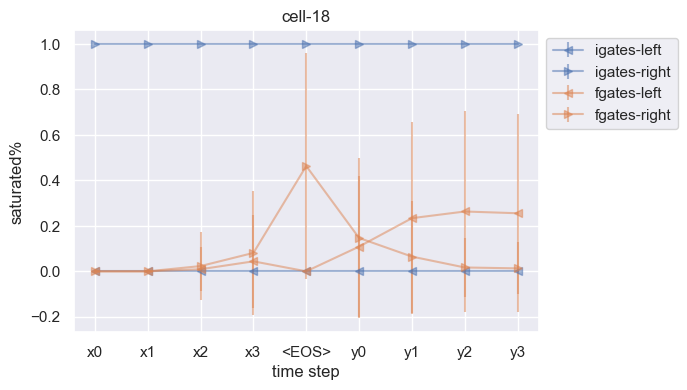

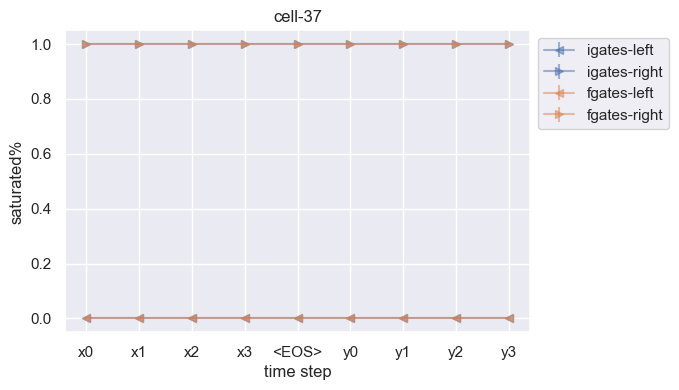

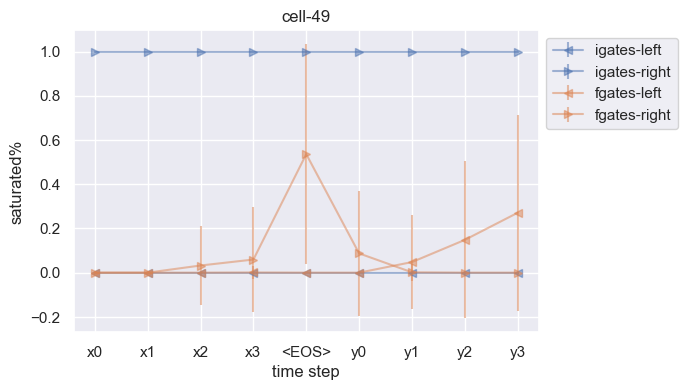

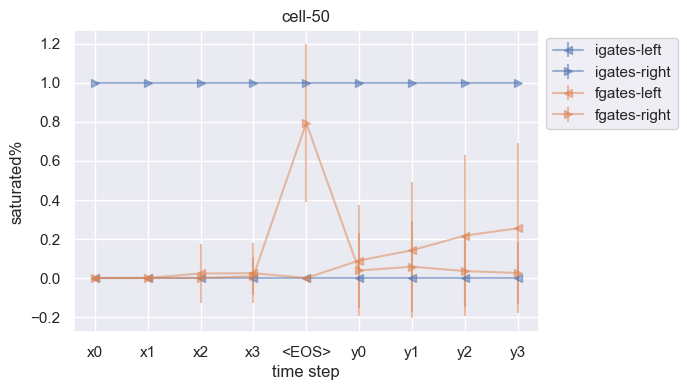

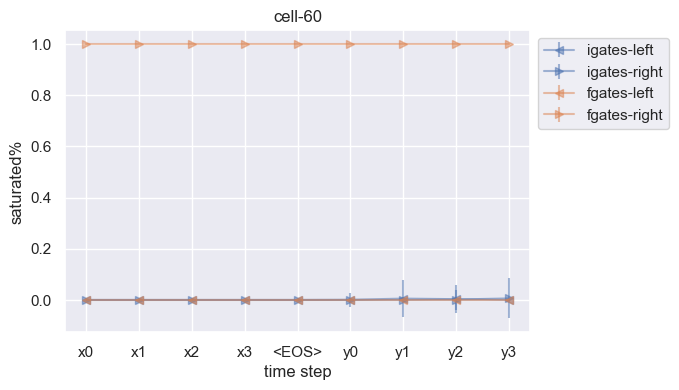

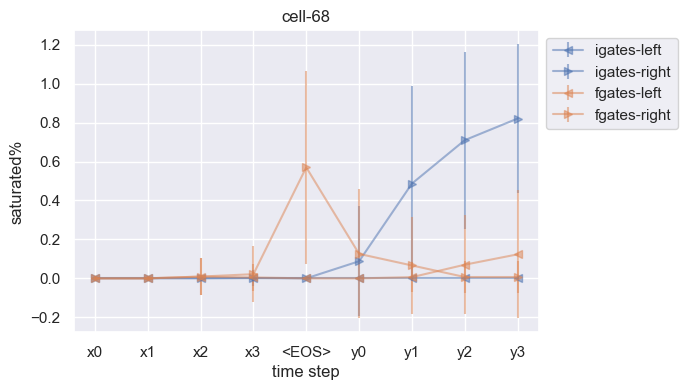

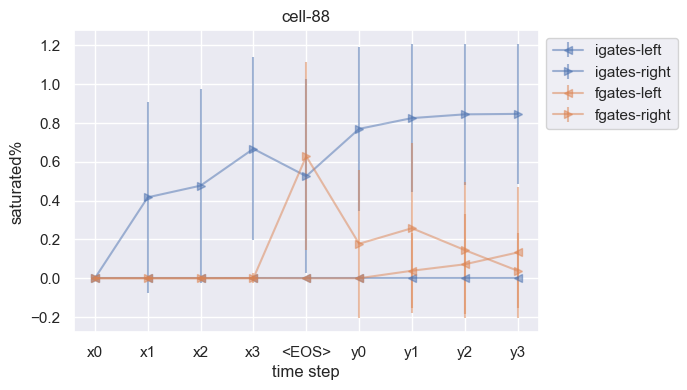

In [46]:
for cidx in set2:
    aio(cidx)